# Simulate Blood Pressure and BFi to fill N-bins ##

What is a simulation technique to quantify the amount of arterial blood pressure variation needed to fill an n-amount of bins with data to allow for a proper fit of a U-shape polynomial? The n-bins are 5mmHg of width. 

The goal is to quantify the amount of bins and which bins need to be filled with data to allow for a U-shape (polynomial) fit. 

The context of the data is ABP and BFi. The correlation values of ABP and BFi follow a U-shape dependency. However, for the simulation you could use any kind of signal1 and signal2, as long as their correlation values follow a U-shape. 

The idea is now to find out which bins and how many bins need to be filled to get a good fit of the U-shape. The difficulty is that:
- if ABP bins filled are only around 60mmHg, e.g. 50, 55, 60 bins, then the data points are close to each other, and highly likely that fitting a U-shape would be difficult. (But this need to be checked. This means there need to be probably some spread of the bins that are filled. However, it needs to be determined what this spread of bins is, and when the fit is ok, i.e. good R2 value or a different measure. 

Use any kind of theoretical simulated signal to allow to do this

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

In [2]:
# create MAP range of 20-200 with 5mmHg increments
MAP = np.arange(20, 205, 5)
print(len(MAP))
MAP

37


array([ 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
        85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145,
       150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200])

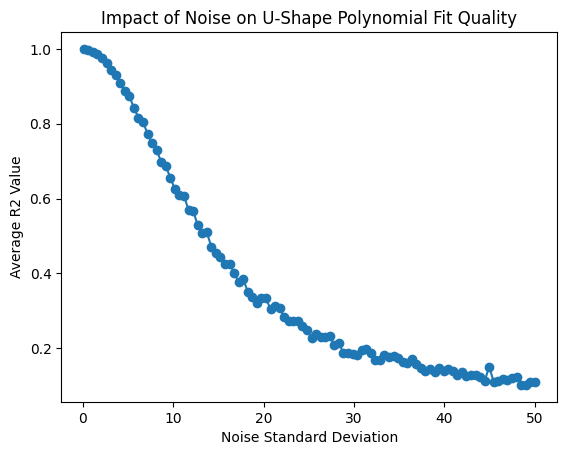

In [3]:

# # Function to generate U-shape polynomial data with noise
# def generate_data(size, noise_std):
#     x = np.linspace(0, 10, size)
#     y_true = x**2 - 10*x + 25
#     noise = np.random.normal(0, noise_std, size)
#     y_noisy = y_true + noise
#     return x, y_noisy, y_true

def generate_data(bin_size, noise_std):
    x = np.arange(20, 205, bin_size)  # MAP
    size = len(x)
    h = x[size // 2]  # Midpoint of x
    a = 1  # Coefficient a controls the "width" of the U-shape
    k = 25  # Coefficient k controls the "height" of the U-shape
    y_true = a * (x - h)**2 + k
    # noise = np.random.normal(0, noise_std, size)
    scaled_noise_std = noise_std * x.max()  # Scale noise_std by the maximum x value
    noise = np.random.normal(0, scaled_noise_std, size)
    y_noisy = y_true + noise
    return x, y_noisy, y_true

# Function to fit a U-shape polynomial and calculate R2
def fit_polynomial_and_calculate_r2(x, y, degree):
    coefficients = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coefficients)
    y_poly = polynomial(x)
    r2 = r2_score(y, y_poly)
    return r2, polynomial

# Simulation parameters
num_simulations = 100
# data_size = 50
bin_size = 5
min_noise_std = 0.1
max_noise_std = 50.0
degree_of_polynomial = 2  # Quadratic U-shape

# Arrays to store results
noise_levels = np.linspace(min_noise_std, max_noise_std, num_simulations)
r2_values = np.zeros_like(noise_levels)

# Simulate and fit for different noise levels
for i, noise_std in enumerate(noise_levels):
    total_r2 = 0
    for _ in range(num_simulations):
        # x, y_noisy, y_true = generate_data(data_size, noise_std)
        x, y_noisy, y_true = generate_data(bin_size, noise_std)
        r2, _ = fit_polynomial_and_calculate_r2(x, y_noisy, degree_of_polynomial)
        total_r2 += r2
    average_r2 = total_r2 / num_simulations
    r2_values[i] = average_r2

# Plotting results
plt.plot(noise_levels, r2_values, marker='o')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Average R2 Value')
plt.title('Impact of Noise on U-Shape Polynomial Fit Quality')
plt.show()


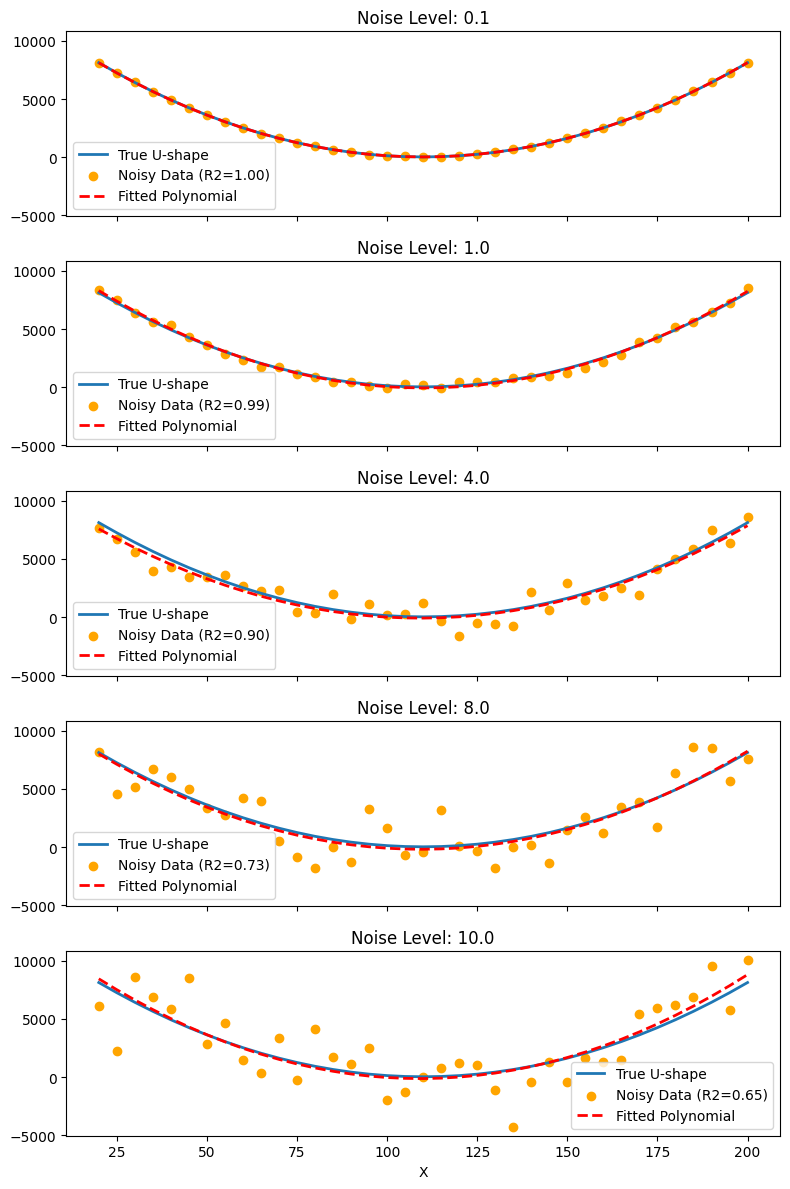

In [4]:
# Simulation parameters
num_simulations = 5
bin_size = 5
# data_size = 50
noise_levels = [0.1, 1.0, 4.0, 8.0, 10.0]  # Example noise levels
degree_of_polynomial = 2  # Quadratic U-shape

# Plotting results
fig, axs = plt.subplots(len(noise_levels), 1, figsize=(8, 12), sharex=True, sharey=True)

for i, noise_std in enumerate(noise_levels):
    axs[i].set_title(f'Noise Level: {noise_std}')
    
    # Simulate and fit for different noise levels
    # x, y_noisy, y_true = generate_data(data_size, noise_std)
    x, y_noisy, y_true = generate_data(bin_size, noise_std)
    r2, polynomial = fit_polynomial_and_calculate_r2(x, y_noisy, degree_of_polynomial)
    
    # Plot true U-shape, noisy data, and fitted polynomial
    axs[i].plot(x, y_true, label='True U-shape', linewidth=2)
    axs[i].scatter(x, y_noisy, label=f'Noisy Data (R2={r2:.2f})', color='orange')
    axs[i].plot(x, polynomial(x), label='Fitted Polynomial', linestyle='--', color='red', linewidth=2)
    
    axs[i].legend()

plt.xlabel('X')
plt.tight_layout()
plt.show()


In [5]:
def binned_autoreg_fit_poly(mean_autoreg, degree):
    """
    Fit a polynomial curve through the midpoints of the bins.

    This function takes a pandas Series or DataFrame with categorical index and corresponding values.
    It fits a polynomial curve through the midpoints of the bins defined by the categorical index.
    The polynomial degree should be specified before calling the function.

    Args:
        mean_autoreg (pandas.Series or pandas.DataFrame): A pandas Series or DataFrame with categorical index
                                                    representing the bins' midpoints and corresponding values.

    Returns:
        tuple: A tuple containing three elements:
               - x (numpy.ndarray): Midpoints of the bins extracted from the categorical index.
               - y (pandas.Series or pandas.DataFrame): Corresponding values for each bin.
               - curve (numpy.ndarray or None): The fitted polynomial curve evaluated at the bin midpoints.
                                                If an error occurs during fitting, it will be set to None.
    """
    # Fit a polynomial curve through the midpoints of the bins
    x = mean_autoreg.index.categories.mid
    y = mean_autoreg
    try:
        coeffs = np.polyfit(x, y, degree)
        curve = np.polyval(coeffs, x)
    except np.linalg.LinAlgError:
        print("Error: SVD did not converge in Linear Least Squares")
        curve = None

    return x, y, curve

/tmp/ipykernel_233417/427195401.py:16: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
/tmp/ipykernel_233417/427195401.py:16: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
/tmp/ipykernel_233417/427195401.py:16: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
/tmp/ipykernel_233417/427195401.py:16: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
/tmp/ipykernel_233417/427195401.py:16: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)


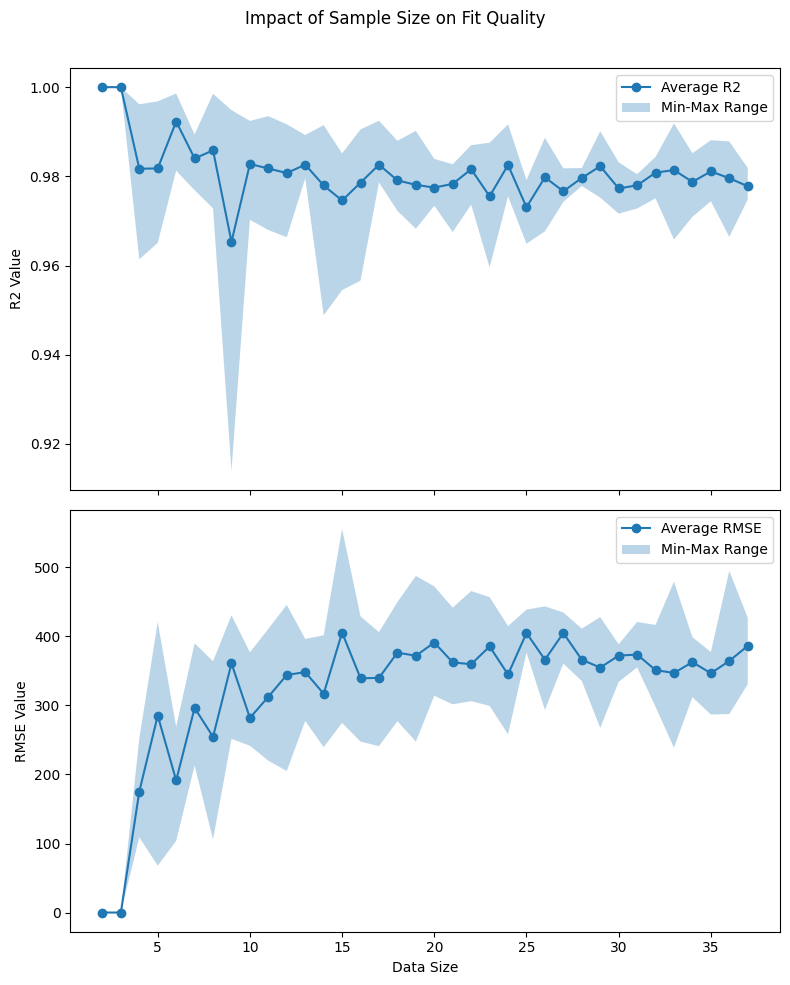

In [6]:
def generate_data(bin_size, noise_std):
    x = np.arange(20, 205, bin_size)  # MAP
    size = len(x)
    h = x[size // 2]  # Midpoint of x
    a = 1  # Coefficient a controls the "width" of the U-shape
    k = 25  # Coefficient k controls the "height" of the U-shape
    y_true = a * (x - h)**2 + k
    # noise = np.random.normal(0, noise_std, size)
    scaled_noise_std = noise_std * x.max()  # Scale noise_std by the maximum x value
    noise = np.random.normal(0, scaled_noise_std, size)
    y_noisy = y_true + noise
    return x, y_noisy, y_true

# Function to fit a U-shape polynomial and calculate metrics
def fit_polynomial_and_calculate_metrics(x, y, degree):
    coefficients = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coefficients)
    y_poly = polynomial(x)
    
    r2 = r2_score(y, y_poly)
    mse = mean_squared_error(y, y_poly)
    rmse = np.sqrt(mse)
    
    return r2, mse, rmse, polynomial

# Simulation parameters
num_simulations = 5
min_data_size = 2
bin_size = 5
noise_level = 2.0
degree_of_polynomial = 2  # Quadratic U-shape

# Generate data to get max_data_size
x, _, _ = generate_data(bin_size, noise_level)
max_data_size = len(x)

# Arrays to store results
data_sizes = np.arange(min_data_size, max_data_size + 1)
r2_values = np.zeros((num_simulations, len(data_sizes)))
mse_values = np.zeros_like(r2_values)
rmse_values = np.zeros_like(r2_values)

# Plotting results
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

for i in range(num_simulations):
    for j, data_size in enumerate(data_sizes):
        x, y_noisy, y_true = generate_data(bin_size, noise_level)
        indices = np.random.choice(len(x), data_size, replace=False)  # Generate random indices
        x = x[indices]
        y_noisy = y_noisy[indices]
        y_true = y_true[indices]
        r2, mse, rmse, _ = fit_polynomial_and_calculate_metrics(x, y_noisy, degree_of_polynomial)
        
        r2_values[i, j] = r2
        mse_values[i, j] = mse
        rmse_values[i, j] = rmse

# Plot R2 values
axs[0].plot(data_sizes, np.mean(r2_values, axis=0), marker='o', label='Average R2')
axs[0].fill_between(data_sizes, np.min(r2_values, axis=0), np.max(r2_values, axis=0), alpha=0.3, label='Min-Max Range')
axs[0].set_ylabel('R2 Value')
axs[0].legend()

# Plot RMSE values
axs[1].plot(data_sizes, np.mean(rmse_values, axis=0), marker='o', label='Average RMSE')
axs[1].fill_between(data_sizes, np.min(rmse_values, axis=0), np.max(rmse_values, axis=0), alpha=0.3, label='Min-Max Range')
axs[1].set_xlabel('Data Size')
axs[1].set_ylabel('RMSE Value')
axs[1].legend()

plt.suptitle('Impact of Sample Size on Fit Quality')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


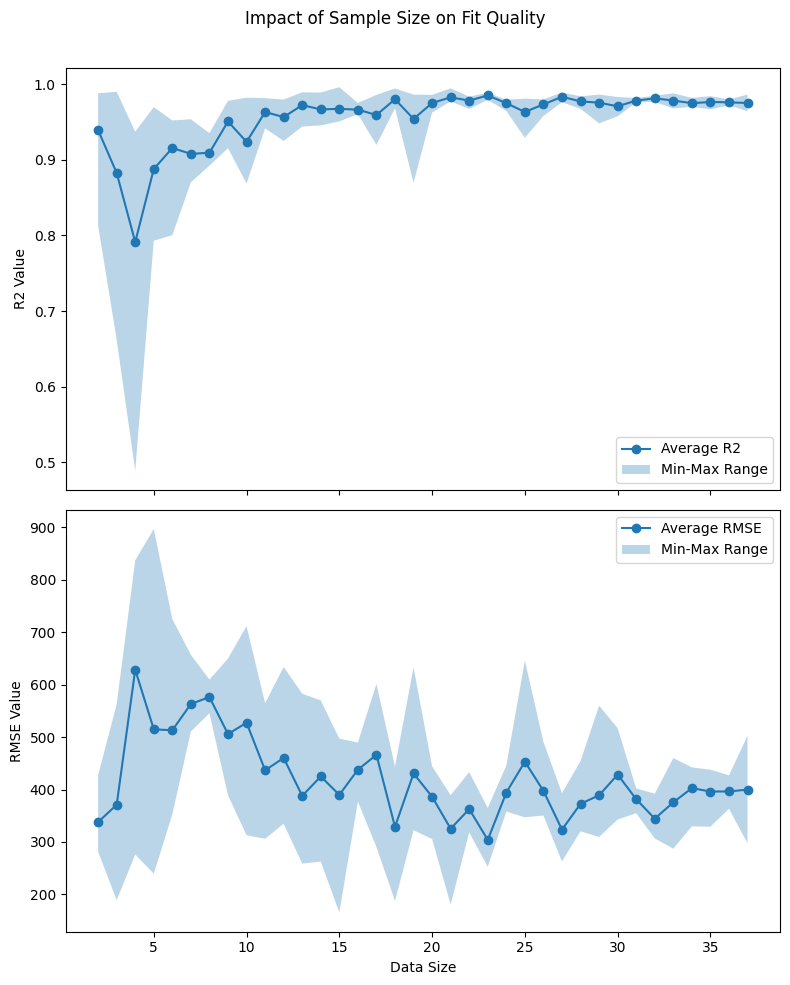

In [7]:
def generate_data(bin_size, noise_std):
    x = np.arange(20, 205, bin_size)  # MAP
    size = len(x)
    h = x[size // 2]  # Midpoint of x
    a = 1  # Coefficient a controls the "width" of the U-shape
    k = 25  # Coefficient k controls the "height" of the U-shape
    y_true = a * (x - h)**2 + k
    # noise = np.random.normal(0, noise_std, size)
    scaled_noise_std = noise_std * x.max()  # Scale noise_std by the maximum x value
    noise = np.random.normal(0, scaled_noise_std, size)
    y_noisy = y_true + noise
    return x, y_noisy, y_true

# Function to fit a U-shape polynomial and calculate metrics
def fit_polynomial_and_calculate_metrics(x, y, degree):
    coefficients = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coefficients)
    y_poly = polynomial(x)
    
    r2 = r2_score(y, y_poly)
    mse = mean_squared_error(y, y_poly)
    rmse = np.sqrt(mse)
    
    return r2, mse, rmse, polynomial

# Simulation parameters
num_simulations = 5
min_data_size = 2
bin_size = 5
noise_level = 2.0
degree_of_polynomial = 2  # Quadratic U-shape

# Generate data to get max_data_size
x, _, _ = generate_data(bin_size, noise_level)
max_data_size = len(x)

# Arrays to store results
data_sizes = np.arange(min_data_size, max_data_size + 1)
r2_values = np.zeros((num_simulations, len(data_sizes)))
mse_values = np.zeros_like(r2_values)
rmse_values = np.zeros_like(r2_values)

# Plotting results
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

for i in range(num_simulations):
    for j, data_size in enumerate(data_sizes):
        x_full, y_noisy, y_true = generate_data(bin_size, noise_level)
        y_noisy_full = np.full(len(x_full), np.nan)  # Create a full array of NaN values

        indices = np.random.choice(len(x_full), data_size, replace=False)  # Generate random indices
        x = x_full[indices]
        y = y_noisy[indices]
        y_noisy_full[indices] = y  # Fill in the randomly selected values

        # Interpolate the missing values
        valid_indices = ~np.isnan(y_noisy_full)
        y_noisy_interpolated = np.interp(x_full, x_full[valid_indices], y_noisy_full[valid_indices])

        r2, mse, rmse, _ = fit_polynomial_and_calculate_metrics(x_full, y_noisy_interpolated, degree_of_polynomial)
        
        r2_values[i, j] = r2
        mse_values[i, j] = mse
        rmse_values[i, j] = rmse

# Plot R2 values
axs[0].plot(data_sizes, np.mean(r2_values, axis=0), marker='o', label='Average R2')
axs[0].fill_between(data_sizes, np.min(r2_values, axis=0), np.max(r2_values, axis=0), alpha=0.3, label='Min-Max Range')
axs[0].set_ylabel('R2 Value')
axs[0].legend()

# Plot RMSE values
axs[1].plot(data_sizes, np.mean(rmse_values, axis=0), marker='o', label='Average RMSE')
axs[1].fill_between(data_sizes, np.min(rmse_values, axis=0), np.max(rmse_values, axis=0), alpha=0.3, label='Min-Max Range')
axs[1].set_xlabel('Data Size')
axs[1].set_ylabel('RMSE Value')
axs[1].legend()

plt.suptitle('Impact of Sample Size on Fit Quality')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


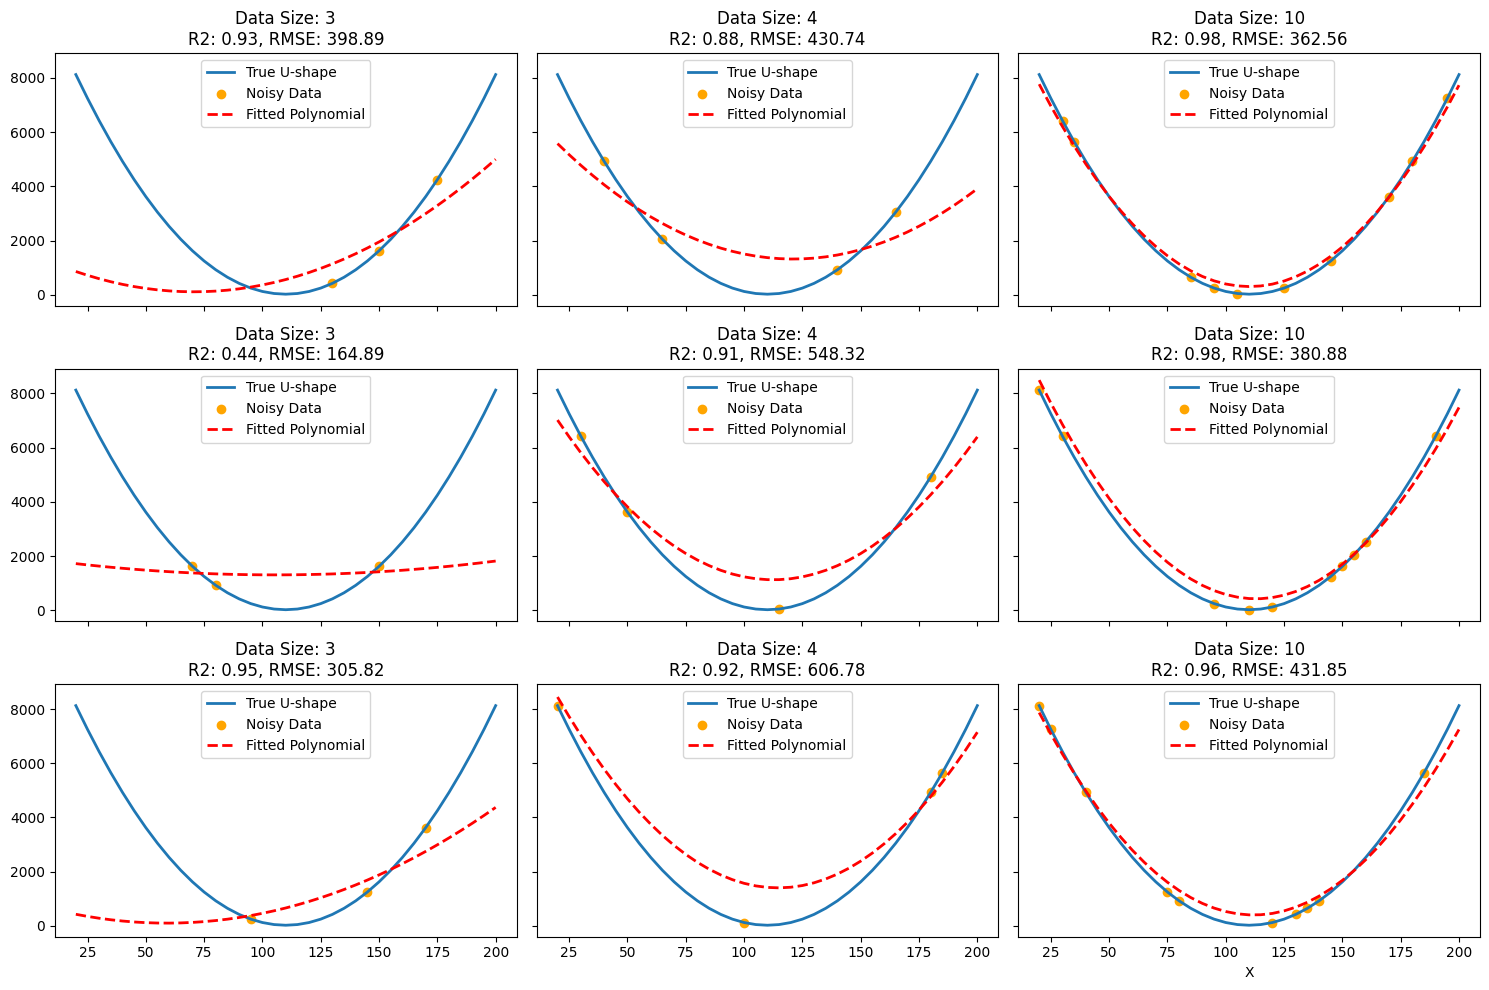

In [8]:
# Function to plot example plots
def plot_example_plots(data_sizes, noise_level, degree_of_polynomial):
    num_examples = 3  # Number of example plots to show
    fig, axs = plt.subplots(num_examples, len(data_sizes), figsize=(15, 10), sharex=True, sharey=True)

    for j, data_size in enumerate(data_sizes):
        for i in range(num_examples):
            x_full, y_noisy, y_true = generate_data(bin_size, noise_level)
            y_noisy_full = np.full(len(x_full), np.nan)  # Create a full array of NaN values

            indices = np.random.choice(len(x_full), data_size, replace=False)  # Generate random indices
            x = x_full[indices]
            y = y_noisy[indices]
            y_noisy_full[indices] = y  # Fill in the randomly selected values

            # Interpolate the missing values
            valid_indices = ~np.isnan(y_noisy_full)
            y_noisy_interpolated = np.interp(x_full, x_full[valid_indices], y_noisy_full[valid_indices])

            r2, mse, rmse, polynomial = fit_polynomial_and_calculate_metrics(x_full, y_noisy_interpolated, degree_of_polynomial)
            
            axs[i, j].set_title(f'Data Size: {data_size}\nR2: {r2:.2f}, RMSE: {rmse:.2f}')
            axs[i, j].plot(x_full, y_true, label='True U-shape', linewidth=2)
            axs[i, j].scatter(x_full, y_noisy_full, label='Noisy Data', color='orange')
            axs[i, j].plot(x_full, polynomial(x_full), label='Fitted Polynomial', linestyle='--', color='red', linewidth=2)
            axs[i, j].legend()

    plt.xlabel('X')
    plt.tight_layout()
    plt.show()

# Simulation parameters
num_simulations = 5
data_sizes = [3, 4, 10]  # Example data sizes
noise_level = 0.0
degree_of_polynomial = 2  # Quadratic U-shape

# Plot example plots
plot_example_plots(data_sizes, noise_level, degree_of_polynomial)


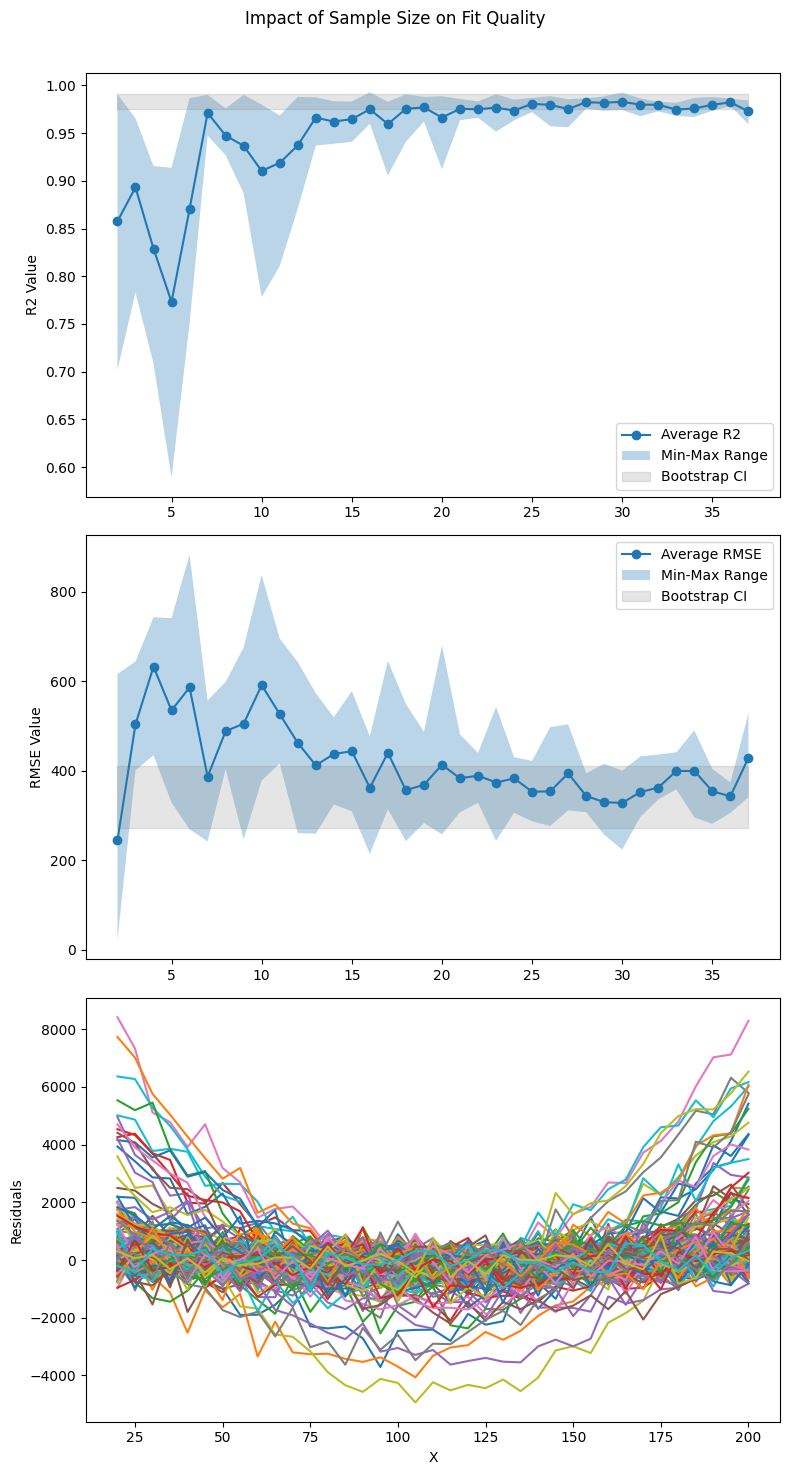

In [9]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.utils import resample
from scipy.stats import t

def generate_data(bin_size, noise_std):
    x = np.arange(20, 205, bin_size)  # MAP
    size = len(x)
    h = x[size // 2]  # Midpoint of x
    a = 1  # Coefficient a controls the "width" of the U-shape
    k = 25  # Coefficient k controls the "height" of the U-shape
    y_true = a * (x - h)**2 + k
    # noise = np.random.normal(0, noise_std, size)
    scaled_noise_std = noise_std * x.max()  # Scale noise_std by the maximum x value
    noise = np.random.normal(0, scaled_noise_std, size)
    y_noisy = y_true + noise
    return x, y_noisy, y_true

# Function to fit a U-shape polynomial and calculate metrics
def fit_polynomial_and_calculate_metrics(x, y, degree):
    coefficients = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coefficients)
    y_poly = polynomial(x)
    
    r2 = r2_score(y, y_poly)
    mse = mean_squared_error(y, y_poly)
    rmse = np.sqrt(mse)
    
    return r2, mse, rmse, polynomial


# Function to perform bootstrap and calculate confidence intervals
def bootstrap_r2(x, y, degree, num_bootstraps, alpha=0.05):
    r2_bootstraps = np.zeros(num_bootstraps)
    
    for i in range(num_bootstraps):
        x_bootstrap, y_bootstrap = resample(x, y)
        _, _, _, polynomial = fit_polynomial_and_calculate_metrics(x_bootstrap, y_bootstrap, degree)
        r2_bootstraps[i] = r2_score(y_bootstrap, polynomial(x_bootstrap))
    
    lower_bound = np.percentile(r2_bootstraps, 100 * alpha / 2)
    upper_bound = np.percentile(r2_bootstraps, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

# Function to perform bootstrap and calculate confidence intervals for RMSE
def bootstrap_rmse(x, y, degree, num_bootstraps, alpha=0.05):
    rmse_bootstraps = np.zeros(num_bootstraps)
    
    for i in range(num_bootstraps):
        x_bootstrap, y_bootstrap = resample(x, y)
        _, _, rmse, _ = fit_polynomial_and_calculate_metrics(x_bootstrap, y_bootstrap, degree)
        rmse_bootstraps[i] = rmse
    
    lower_bound = np.percentile(rmse_bootstraps, 100 * alpha / 2)
    upper_bound = np.percentile(rmse_bootstraps, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

# Function to calculate BCa confidence intervals
def calculate_bca_confidence_intervals(bootstraps, statistic, alpha=0.05):
    ordered_bootstraps = np.sort(bootstraps)
    lower_bound_index = int(np.ceil(alpha / 2 * len(bootstraps)))
    upper_bound_index = int(np.floor((1 - alpha / 2) * len(bootstraps)))
    point_estimate = statistic(bootstraps)
    
    # Acceleration term
    acceleration = np.sum((bootstraps - point_estimate) ** 3) / (6 * np.sum((bootstraps - point_estimate) ** 2) ** 1.5)
    
    # Bias correction
    z0 = t.ppf((np.sum(ordered_bootstraps < point_estimate) + 0.5) / len(bootstraps))
    z_alpha_low = t.ppf(alpha / 2)
    z_alpha_high = t.ppf(1 - alpha / 2)
    bias_correction_low = z0 + (z0 + z_alpha_low) / (1 - acceleration * (z0 + z_alpha_low))
    bias_correction_high = z0 + (z0 + z_alpha_high) / (1 - acceleration * (z0 + z_alpha_high))
    
    # Corrected percentiles
    corrected_percentiles = np.array([np.percentile(bootstraps, 100 * alpha / 2),
                                     np.percentile(bootstraps, 100 * (1 - alpha / 2))])
    
    # Calculate corrected bounds
    corrected_lower_bound = point_estimate + (corrected_percentiles[0] - point_estimate) * bias_correction_low


# Simulation parameters
n_bootstrap = 30    
num_simulations = 5
min_data_size = 2
bin_size = 5
noise_level = 2.0
degree_of_polynomial = 2  # Quadratic U-shape

# Generate data to get max_data_size
x, _, _ = generate_data(bin_size, noise_level)
max_data_size = len(x)

# Arrays to store results
data_sizes = np.arange(min_data_size, max_data_size + 1)
r2_values = np.zeros((num_simulations, len(data_sizes)))
mse_values = np.zeros_like(r2_values)
rmse_values = np.zeros_like(r2_values)


# Plotting results
fig, axs = plt.subplots(3, 1, figsize=(8, 15), sharex=False)

for i in range(num_simulations):
    for j, data_size in enumerate(data_sizes):
        x_full, y_noisy, y_true = generate_data(bin_size, noise_level)
        y_noisy_full = np.full(len(x_full), np.nan)  # Create a full array of NaN values

        indices = np.random.choice(len(x_full), data_size, replace=False)  # Generate random indices
        x = x_full[indices]
        y = y_noisy[indices]
        y_noisy_full[indices] = y  # Fill in the randomly selected values

        # Interpolate the missing values
        valid_indices = ~np.isnan(y_noisy_full)
        y_noisy_interpolated = np.interp(x_full, x_full[valid_indices], y_noisy_full[valid_indices])

        r2, mse, rmse, _ = fit_polynomial_and_calculate_metrics(x_full, y_noisy_interpolated, degree_of_polynomial)
        
        # Bootstrap confidence intervals for R2
        lower_bound, upper_bound = bootstrap_r2(x_full, y_noisy_interpolated, degree_of_polynomial, n_bootstrap)
        lower_bound_rmse, upper_bound_rmse = bootstrap_rmse(x_full, y_noisy_interpolated, degree_of_polynomial, n_bootstrap)
        
        r2_values[i, j] = r2
        mse_values[i, j] = mse
        rmse_values[i, j] = rmse

        # Plot residuals
        residuals = y_noisy - np.polyval(np.polyfit(x_full, y_noisy_interpolated, degree_of_polynomial, full=True)[0], x_full)
        axs[2].plot(x_full, residuals, label=f'Data Size: {data_size}')


# Plot R2 values with bootstrap confidence intervals
axs[0].plot(data_sizes, np.mean(r2_values, axis=0), marker='o', label='Average R2')
axs[0].fill_between(data_sizes, np.min(r2_values, axis=0), np.max(r2_values, axis=0), alpha=0.3, label='Min-Max Range')
axs[0].fill_between(data_sizes, np.tile(lower_bound, len(data_sizes)), np.tile(upper_bound, len(data_sizes)),
                    color='gray', alpha=0.2, label='Bootstrap CI')
axs[0].set_ylabel('R2 Value')
axs[0].legend()

# Plot RMSE values with bootstrap confidence intervals
axs[1].plot(data_sizes, np.mean(rmse_values, axis=0), marker='o', label='Average RMSE')
axs[1].fill_between(data_sizes, np.min(rmse_values, axis=0), np.max(rmse_values, axis=0), alpha=0.3, label='Min-Max Range')
axs[1].fill_between(data_sizes, np.tile(lower_bound_rmse, len(data_sizes)), np.tile(upper_bound_rmse, len(data_sizes)),
                    color='gray', alpha=0.2, label='Bootstrap CI')
axs[1].set_ylabel('RMSE Value')
axs[1].legend()

# Plot residuals
axs[2].set_xlabel('X')
axs[2].set_ylabel('Residuals')
# axs[2].legend()

plt.suptitle('Impact of Sample Size on Fit Quality')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

/tmp/ipykernel_233417/2327945846.py:52: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  y_zscore_bootstraps[i] = zscore(y_bootstrap)
/tmp/ipykernel_233417/2327945846.py:52: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  y_zscore_bootstraps[i] = zscore(y_bootstrap)
/tmp/ipykernel_233417/2327945846.py:52: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  y_zscore_bootstraps[i] = zscore(y_bootstrap)
/tmp/ipykernel_233417/2327945846.py:52: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  y_zscore_boot

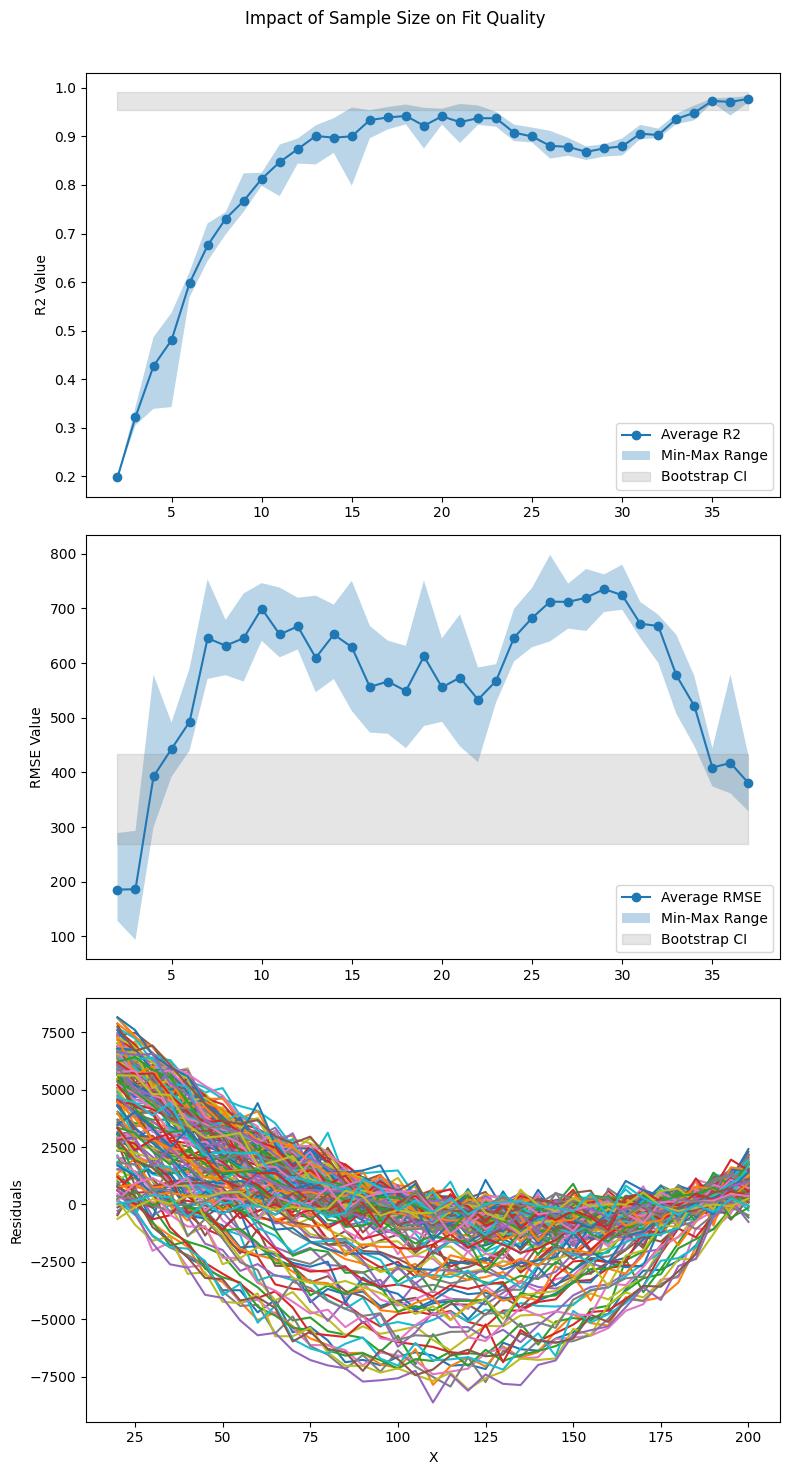

In [10]:
# Now instead of Random Normal selection, use a Gamma distribution to select the data points

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.utils import resample
from scipy.stats import t
from scipy.stats import zscore

def generate_data(bin_size, noise_std):
    x = np.arange(20, 205, bin_size)  # MAP
    size = len(x)
    h = x[size // 2]  # Midpoint of x
    a = 1  # Coefficient a controls the "width" of the U-shape
    k = 25  # Coefficient k controls the "height" of the U-shape
    y_true = a * (x - h)**2 + k
    # noise = np.random.normal(0, noise_std, size)
    scaled_noise_std = noise_std * x.max()  # Scale noise_std by the maximum x value
    noise = np.random.normal(0, scaled_noise_std, size)
    y_noisy = y_true + noise
    return x, y_noisy, y_true

# Function to fit a U-shape polynomial and calculate metrics
def fit_polynomial_and_calculate_metrics(x, y, degree):
    coefficients = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coefficients)
    y_poly = polynomial(x)
    
    r2 = r2_score(y, y_poly)
    mse = mean_squared_error(y, y_poly)
    rmse = np.sqrt(mse)
    
    return r2, mse, rmse, polynomial



# Function to perform bootstrap and calculate confidence intervals
def bootstrap_r2(x, y, degree, num_bootstraps, alpha=0.05):
    r2_bootstraps = np.zeros(num_bootstraps)
    y_mean_bootstraps = np.zeros(num_bootstraps)
    y_std_bootstraps = np.zeros(num_bootstraps)
    y_zscore_bootstraps = np.zeros((num_bootstraps, len(y)))
    
    for i in range(num_bootstraps):
        x_bootstrap, y_bootstrap = resample(x, y)
        _, _, _, polynomial = fit_polynomial_and_calculate_metrics(x_bootstrap, y_bootstrap, degree)
        r2_bootstraps[i] = r2_score(y_bootstrap, polynomial(x_bootstrap))
        
        # Calculate mean, std, and z-score of y_bootstrap
        y_mean_bootstraps[i] = np.mean(y_bootstrap)
        y_std_bootstraps[i] = np.std(y_bootstrap)
        y_zscore_bootstraps[i] = zscore(y_bootstrap)
    
    lower_bound = np.percentile(r2_bootstraps, 100 * alpha / 2)
    upper_bound = np.percentile(r2_bootstraps, 100 * (1 - alpha / 2))

    # Calculate overall mean, std, and z-score
    overall_mean = np.mean(y_mean_bootstraps)
    overall_std = np.std(y_std_bootstraps)
    overall_zscore = np.mean(y_zscore_bootstraps)
    
    return lower_bound, upper_bound, overall_mean, overall_std, overall_zscore

# Function to perform bootstrap and calculate confidence intervals for RMSE
def bootstrap_rmse(x, y, degree, num_bootstraps, alpha=0.05):
    rmse_bootstraps = np.zeros(num_bootstraps)
    
    for i in range(num_bootstraps):
        x_bootstrap, y_bootstrap = resample(x, y)
        _, _, rmse, _ = fit_polynomial_and_calculate_metrics(x_bootstrap, y_bootstrap, degree)
        rmse_bootstraps[i] = rmse
    
    lower_bound = np.percentile(rmse_bootstraps, 100 * alpha / 2)
    upper_bound = np.percentile(rmse_bootstraps, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

# Function to calculate BCa confidence intervals
def calculate_bca_confidence_intervals(bootstraps, statistic, alpha=0.05):
    ordered_bootstraps = np.sort(bootstraps)
    lower_bound_index = int(np.ceil(alpha / 2 * len(bootstraps)))
    upper_bound_index = int(np.floor((1 - alpha / 2) * len(bootstraps)))
    point_estimate = statistic(bootstraps)
    
    # Acceleration term
    acceleration = np.sum((bootstraps - point_estimate) ** 3) / (6 * np.sum((bootstraps - point_estimate) ** 2) ** 1.5)
    
    # Bias correction
    z0 = t.ppf((np.sum(ordered_bootstraps < point_estimate) + 0.5) / len(bootstraps))
    z_alpha_low = t.ppf(alpha / 2)
    z_alpha_high = t.ppf(1 - alpha / 2)
    bias_correction_low = z0 + (z0 + z_alpha_low) / (1 - acceleration * (z0 + z_alpha_low))
    bias_correction_high = z0 + (z0 + z_alpha_high) / (1 - acceleration * (z0 + z_alpha_high))
    
    # Corrected percentiles
    corrected_percentiles = np.array([np.percentile(bootstraps, 100 * alpha / 2),
                                     np.percentile(bootstraps, 100 * (1 - alpha / 2))])
    
    # Calculate corrected bounds
    corrected_lower_bound = point_estimate + (corrected_percentiles[0] - point_estimate) * bias_correction_low


# Simulation parameters
n_bootstrap = 30    
num_simulations = 5
min_data_size = 2
bin_size = 5
noise_level = 2.0
degree_of_polynomial = 2  # Quadratic U-shape

# k_values = [1, 2, 3, 8]  # k is the shape or skewness parameter. In random.gamma, this is the mean
# theta_values = [1, 2, 3, 4]  # spread or scale parameter, in random.gamma, scale is std=2*sqrt(theta) 

k = 150  # shape
theta = 5  # scale

# Generate data to get max_data_size
x, _, _ = generate_data(bin_size, noise_level)
max_data_size = len(x)

# Arrays to store results
data_sizes = np.arange(min_data_size, max_data_size + 1)
r2_values = np.zeros((num_simulations, len(data_sizes)))
mse_values = np.zeros_like(r2_values)
rmse_values = np.zeros_like(r2_values)
y_mean_bootstraps = np.zeros_like(r2_values)
y_std_bootstraps = np.zeros_like(r2_values)
y_zscore_bootstraps = np.zeros_like(r2_values)

# Plotting results
fig, axs = plt.subplots(3, 1, figsize=(8, 15), sharex=False)

for i in range(num_simulations):
    for j, data_size in enumerate(data_sizes):
        x_full, y_noisy, y_true = generate_data(bin_size, noise_level)
        y_noisy_full = np.full(len(x_full), np.nan)  # Create a full array of NaN values

        # Define a skewed probability distribution -> use Gamma Distributions
        probabilities = stats.gamma.pdf(np.linspace(20, 205, len(x_full)), a=k, scale=theta)
        probabilities /= probabilities.sum()  # normalize to sum to 1

        indices = np.random.choice(len(x_full), data_size, replace=False, p=probabilities)  # Generate random indices
        x = x_full[indices]
        y = y_noisy[indices]
        y_noisy_full[indices] = y  # Fill in the randomly selected values

        # Interpolate the missing values
        valid_indices = ~np.isnan(y_noisy_full)
        y_noisy_interpolated = np.interp(x_full, x_full[valid_indices], y_noisy_full[valid_indices])

        r2, mse, rmse, _ = fit_polynomial_and_calculate_metrics(x_full, y_noisy_interpolated, degree_of_polynomial)
        
        # Bootstrap confidence intervals for R2
        lower_bound, upper_bound, overall_mean, overall_std, overall_zscore = bootstrap_r2(x_full, y_noisy_interpolated, degree_of_polynomial, n_bootstrap)
        lower_bound_rmse, upper_bound_rmse = bootstrap_rmse(x_full, y_noisy_interpolated, degree_of_polynomial, n_bootstrap)

        # print("R2")
        # print(r2)
        # print("Y MEAN")
        # print(y_mean_bootstraps)
        # print("LOWER BOUND")
        # print(lower_bound)
        
        r2_values[i, j] = r2
        mse_values[i, j] = mse
        rmse_values[i, j] = rmse
        y_mean_bootstraps[i, j] = overall_mean
        y_std_bootstraps[i, j] = overall_std
        y_zscore_bootstraps[i, j] = overall_zscore

        # Plot residuals
        residuals = y_noisy - np.polyval(np.polyfit(x_full, y_noisy_interpolated, degree_of_polynomial, full=True)[0], x_full)
        axs[2].plot(x_full, residuals, label=f'Data Size: {data_size}')


# Plot R2 values with bootstrap confidence intervals
axs[0].plot(data_sizes, np.mean(r2_values, axis=0), marker='o', label='Average R2')
axs[0].fill_between(data_sizes, np.min(r2_values, axis=0), np.max(r2_values, axis=0), alpha=0.3, label='Min-Max Range')
axs[0].fill_between(data_sizes, np.tile(lower_bound, len(data_sizes)), np.tile(upper_bound, len(data_sizes)),
                    color='gray', alpha=0.2, label='Bootstrap CI')
axs[0].set_ylabel('R2 Value')
axs[0].legend()

# Plot RMSE values with bootstrap confidence intervals
axs[1].plot(data_sizes, np.mean(rmse_values, axis=0), marker='o', label='Average RMSE')
axs[1].fill_between(data_sizes, np.min(rmse_values, axis=0), np.max(rmse_values, axis=0), alpha=0.3, label='Min-Max Range')
axs[1].fill_between(data_sizes, np.tile(lower_bound_rmse, len(data_sizes)), np.tile(upper_bound_rmse, len(data_sizes)),
                    color='gray', alpha=0.2, label='Bootstrap CI')
axs[1].set_ylabel('RMSE Value')
axs[1].legend()

# Plot residuals
axs[2].set_xlabel('X')
axs[2].set_ylabel('Residuals')
# axs[2].legend()

plt.suptitle('Impact of Sample Size on Fit Quality')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [11]:
indices
y_noisy_full

array([8311.64003162, 7559.39331318, 6961.54465988, 6081.57643417,
       4482.99985903, 4412.72584935, 3311.57875641, 3086.4846918 ,
       2546.38892918, 1668.97692301, 1850.85173364, 1198.40237278,
        409.35148372,  310.61253261, 1550.86714066,  991.42917975,
       -131.66764337,  202.94899002, -314.30909534,  306.48705929,
       -344.2089171 ,  237.39313562,  499.09995188,  740.03300298,
        790.98240237, 1057.09540733, 1261.89708124, 2468.11535581,
       1924.48634675, 3791.87575093, 3818.09406671, 4092.61842827,
       4394.02600624, 5533.29988139, 6011.10838095, 7395.99207639,
       7978.27231955])

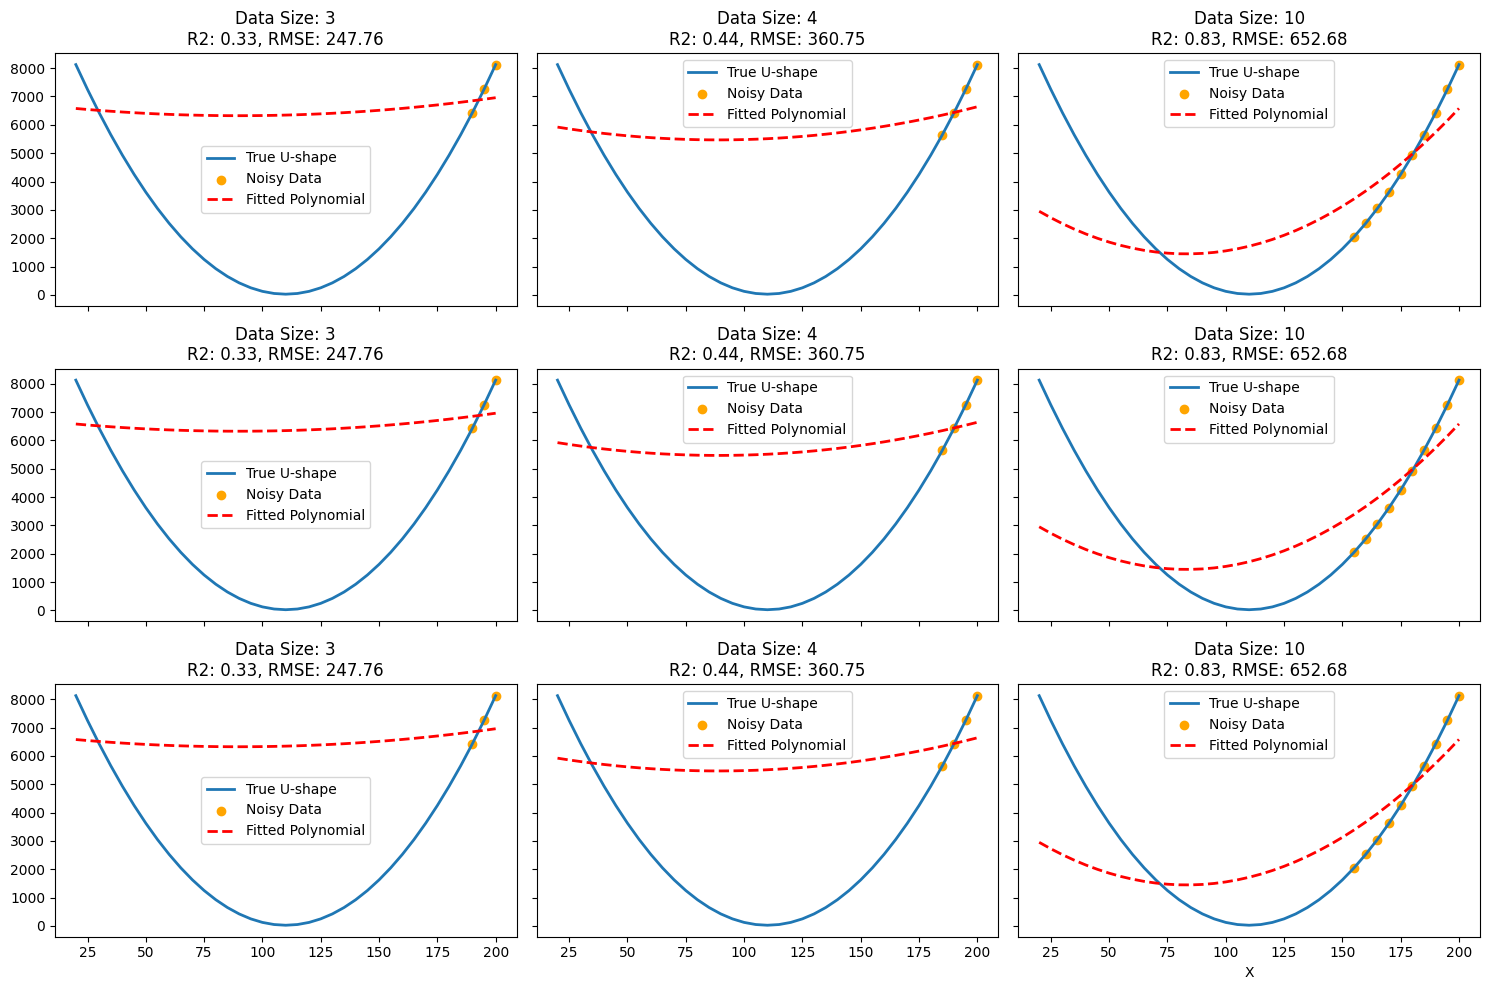

In [12]:
# Sample plot with Gamma Distibution

# Function to plot example plots
def plot_example_plots(data_sizes, noise_level, degree_of_polynomial):
    num_examples = 3  # Number of example plots to show
    fig, axs = plt.subplots(num_examples, len(data_sizes), figsize=(15, 10), sharex=True, sharey=True)

    for j, data_size in enumerate(data_sizes):
        for i in range(num_examples):
            x_full, y_noisy, y_true = generate_data(bin_size, noise_level)
            y_noisy_full = np.full(len(x_full), np.nan)  # Create a full array of NaN values

            # Define a skewed probability distribution -> use Gamma Distributions
            probabilities = stats.gamma.pdf(np.linspace(20, 205, len(x_full)), a=k, scale=theta)
            probabilities /= probabilities.sum()  # normalize to sum to 1

            indices = np.random.choice(len(x_full), data_size, replace=False, p=probabilities)  # Generate random indices
            x = x_full[indices]
            y = y_noisy[indices]
            y_noisy_full[indices] = y  # Fill in the randomly selected values

            # Interpolate the missing values
            valid_indices = ~np.isnan(y_noisy_full)
            y_noisy_interpolated = np.interp(x_full, x_full[valid_indices], y_noisy_full[valid_indices])

            r2, mse, rmse, polynomial = fit_polynomial_and_calculate_metrics(x_full, y_noisy_interpolated, degree_of_polynomial)
            
            axs[i, j].set_title(f'Data Size: {data_size}\nR2: {r2:.2f}, RMSE: {rmse:.2f}')
            axs[i, j].plot(x_full, y_true, label='True U-shape', linewidth=2)
            axs[i, j].scatter(x_full, y_noisy_full, label='Noisy Data', color='orange')
            axs[i, j].plot(x_full, polynomial(x_full), label='Fitted Polynomial', linestyle='--', color='red', linewidth=2)
            axs[i, j].legend()

    plt.xlabel('X')
    plt.tight_layout()
    plt.show()

# Simulation parameters
num_simulations = 5
data_sizes = [3, 4, 10]  # Example data sizes
noise_level = 0.0
degree_of_polynomial = 2  # Quadratic U-shape

# Plot example plots
plot_example_plots(data_sizes, noise_level, degree_of_polynomial)


In [13]:
# extract the normalised CI values from bin=10
        # y_mean_bootstraps[i, j] = overall_mean
        # y_std_bootstraps[i, j] = overall_std
        # y_zscore_bootstraps[i, j] = overall_zscore

# get simulation mean for std and zscore
std_mean = np.mean(y_std_bootstraps, axis=0)
zscore_mean = np.mean(y_zscore_bootstraps, axis=0)
std_mean[9]  # for bin 10


np.float64(318.6868125586516)

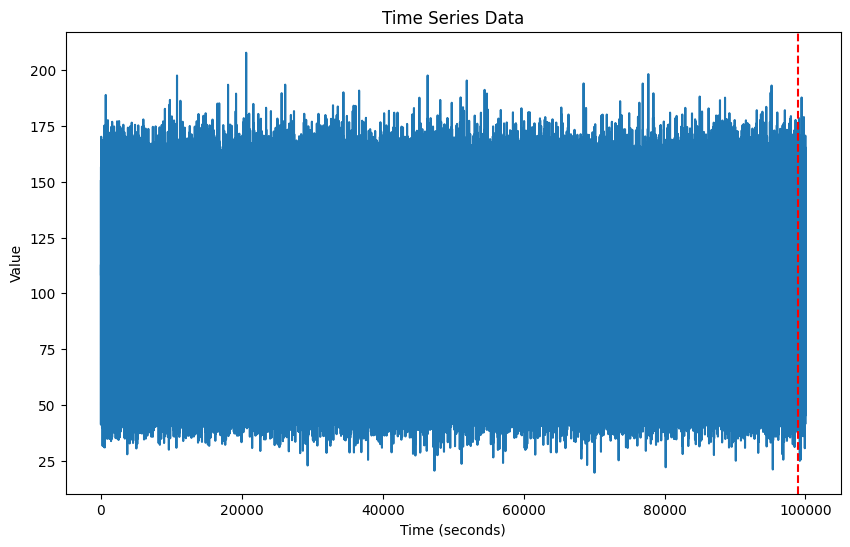

In [14]:
# Parameters
min_abp = 20
max_abp = 205
bin_size = 5

k = 150.0  # shape
theta = 2.0  # scale
noise_level = 2.0

threshold_std = std_mean[9] * 2
threshold_zscore = zscore_mean[9] * 2

# bins
bins = np.linspace(min_abp, max_abp, bin_size)

# time series
n_datapoints = 100_000
fs = 100
time_values = np.arange(0, n_datapoints, 1/fs)  # time values in seconds with increased sampling rate

# Generate gamma distributed values
gamma_values = np.random.gamma(k, theta, len(time_values))
abp_values = ((gamma_values - np.min(gamma_values)) / (np.max(gamma_values) - np.min(gamma_values))) * (max_abp - min_abp) + min_abp
abp_values += np.random.normal(0, noise_level, len(time_values))

# Create a DataFrame
df = pd.DataFrame({'Time': time_values, 'Value': abp_values})

# Initialize the bin_means list
bin_means = [[] for _ in range(len(bins)-1)]
bin_stdevs = [[] for _ in range(len(bins)-1)]
bin_zscores = [[] for _ in range(len(bins)-1)]

# For each n_datapoints
for i in range(0, len(abp_values), n_datapoints):
    # Calculate the mean of the n_datapoints
    mean = np.mean(abp_values[i:i+n_datapoints])
    
    # Determine which bin the mean belongs to
    bin_index = np.digitize(mean, bins) - 1
    
    # Add the mean to the corresponding bin
    bin_means[bin_index].append(mean)
    
    # If there are at least 2 means in the bin, calculate the stdev and zscore
    if len(bin_means[bin_index]) >= 2:
        stdev = np.std(bin_means[bin_index])
        zscore = (mean - np.mean(bin_means[bin_index])) / stdev

        bin_stdevs[bin_index].append(stdev)
        bin_zscores[bin_index].append(zscore)
        
        # If the stdev is less than or equal to threshold_std, add the bin to the filled bins
        if stdev <= threshold_std:
            bin_means[bin_index].append(mean)
    
    # If at least 10 bins have a stdev less than or equal to threshold_std, break the loop
    if len([bin for bin in bin_stdevs if len(bin) >= 1 and bin[-1] <= threshold_std]) >= 10:
        break

# The time it takes to fill 10 bins is the number of iterations it took for the counter to reach 10
time_to_fill_10_bins = (i + 1)

# Get the corresponding time from the DataFrame
time_to_fill_10_bins = df["Time"].iloc[time_to_fill_10_bins]

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Value'])
plt.axvline(x=time_to_fill_10_bins, color='r', linestyle='--')  # add a vertical line at the time_to_fill_10_bins
plt.title('Time Series Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Value')
plt.show()

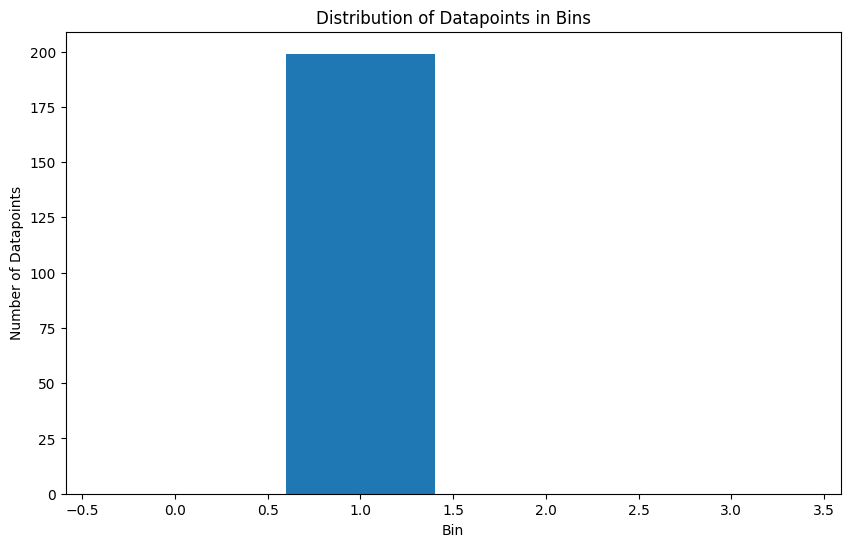

In [15]:
# Calculate the number of datapoints in each bin
datapoints_per_bin = [len(bin) for bin in bin_means]

# Create a DataFrame
df_bins = pd.DataFrame({'Bin': range(len(bins)-1), 'Datapoints': datapoints_per_bin})

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(df_bins['Bin'], df_bins['Datapoints'])
plt.title('Distribution of Datapoints in Bins')
plt.xlabel('Bin')
plt.ylabel('Number of Datapoints')
plt.show()

R2: -13.832455144862449
MSE: 1193.6497967516193


/tmp/ipykernel_233417/203336242.py:15: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample, 2)


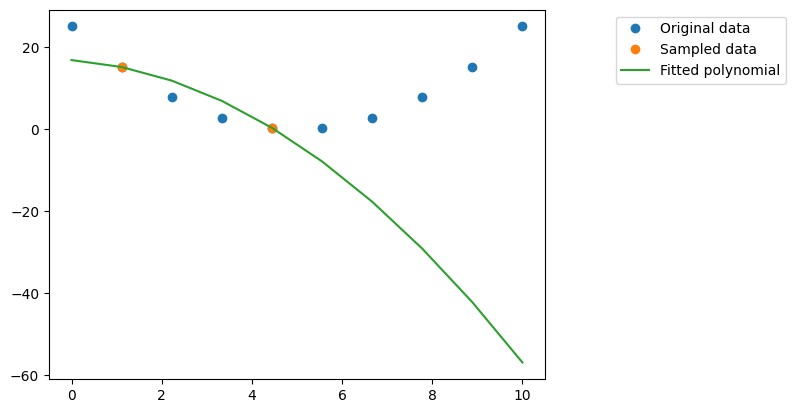

In [16]:
# First, create a U-shape data set. Then randomly sample from it and fit a U-shape. 

# Create a U-shape dataset
x = np.linspace(0, 10, 10)
# y = x**2 - 10*x + 25 + np.random.normal(0, 5, 100)
y_true = x**2 - 10*x + 25 

# Randomly sample from the dataset
sample_size = 2  # this should be iterated over.
random_indices = np.random.choice(np.arange(len(x)), sample_size, replace=False)
x_sample = x[random_indices]
y_sample = y_true[random_indices]

# Fit a U-shape to the sampled data
coefficients = np.polyfit(x_sample, y_sample, 2)
polynomial = np.poly1d(coefficients)
y_poly_sample = polynomial(x)
len(y_poly_sample)

# R2 explains how well the model explains the variance in the target variable. Negative values means worse than a horizontal line
r2 = r2_score(y_true, y_poly_sample)
print("R2:", r2)

# mean squared error: the average squared difference between the actual and predicted values. The higher the MSE, the larger the errors.
mse = mean_squared_error(y_true, y_poly_sample)
print("MSE:", mse)

plt.plot(x, y_true, 'o', label='Original data')
plt.plot(x_sample, y_sample, 'o', label='Sampled data')
plt.plot(x, y_poly_sample, label='Fitted polynomial')
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.show()

## How we sample the data ##
To quantify how many datapoints we need and how they need to be sampled, we need to adjust the way how we sample by assuming a sampling distibution. The skewness and the narrowness of the peak.

Here, we use a Gamma distribution which have two parameters:
- k: the shape parameter
- theta: the scale parameter

https://en.wikipedia.org/wiki/Gamma_distribution

In [17]:
# Define the skewness and spread values to iterate over -> example plots
k_values = [1, 2, 3, 8]  # k is the shape or skewness parameter. In random.gamma, this is the mean
theta_values = [1, 2, 3, 4]  # spread or scale parameter, in random.gamma, scale is std=2*sqrt(theta) 
sample_sizes = [2, 5, 8]

for n_sample in sample_sizes:
    for k in k_values:
        for theta in theta_values:

            # Define a skewed probability distribution -> use Gamma Distributions
            probabilities = stats.gamma.pdf(np.linspace(0, 1, len(x)), a=k, scale=theta)
            probabilities /= probabilities.sum()  # normalize to sum to 1

            # Randomly sample from the dataset with the specified distribution, this is sampling
            random_indices = np.random.choice(np.arange(len(x)), n_sample, replace=False, p=probabilities)
            x_sample = x[random_indices]
            y_sample = y_true[random_indices]

            # Fit a U-shape to the sampled data
            coefficients = np.polyfit(x_sample, y_sample, 2)
            polynomial = np.poly1d(coefficients)
            y_poly_sample = polynomial(x)

            # Calculate R2 and MSE
            r2 = r2_score(y_true, y_poly_sample)
            print("Skewness:", k, "Spread:", theta, "R2:", r2)
            mse = mean_squared_error(y_true, y_poly_sample)
            print("Skewness:", k, "Spread:", theta, "MSE:", mse)



Skewness: 1 Spread: 1 R2: -1.2209750004012578
Skewness: 1 Spread: 1 MSE: 178.73415641089227
Skewness: 1 Spread: 2 R2: -546.7272727272727
Skewness: 1 Spread: 2 MSE: 44078.64654778235
Skewness: 1 Spread: 3 R2: -2.8263494318181794
Skewness: 1 Spread: 3 MSE: 307.92752629172367
Skewness: 1 Spread: 4 R2: -1.2209750004012578
Skewness: 1 Spread: 4 MSE: 178.73415641089227
Skewness: 2 Spread: 1 R2: -1.8715981140067073
Skewness: 2 Spread: 1 MSE: 231.09340103574783
Skewness: 2 Spread: 2 R2: -1.831237072896184
Skewness: 2 Spread: 2 MSE: 227.84532456777706
Skewness: 2 Spread: 3 R2: -1.1576044224682716
Skewness: 2 Spread: 3 MSE: 173.6343751048998
Skewness: 2 Spread: 4 R2: -6.073841653752542
Skewness: 2 Spread: 4 MSE: 569.2712076179457
Skewness: 3 Spread: 1 R2: -3.785052461118158
Skewness: 3 Spread: 1 MSE: 385.0796676528559
Skewness: 3 Spread: 2 R2: -6.0738416537524795
Skewness: 3 Spread: 2 MSE: 569.2712076179407
Skewness: 3 Spread: 3 R2: -6.073841653752542
Skewness: 3 Spread: 3 MSE: 569.2712076179457

/tmp/ipykernel_233417/8586358.py:20: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample, 2)
/tmp/ipykernel_233417/8586358.py:20: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample, 2)
/tmp/ipykernel_233417/8586358.py:20: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample, 2)
/tmp/ipykernel_233417/8586358.py:20: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample, 2)
/tmp/ipykernel_233417/8586358.py:20: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample, 2)
/tmp/ipykernel_233417/8586358.py:20: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample, 2)
/tmp/ipykernel_233417/8586358.py:20: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample, 2)
/tmp/ipykernel_233417/8586358.py:20: RankWarning: Polyf

In [18]:
len(y_true) // 2

5

In [19]:
# Now iterate over the sample size, skewness and spread. Do this a couple of times so that the
# RMSE, mean and 95% confidence interval of the R2 and MSE values. 
# sample_sizes = np.arange(2, len(y_true)//5, 1)
sample_sizes = [2, 5, 8]
k_values = [1, 2, 3, 8]  # k is the shape or skewness parameter. In random.gamma, this is the mean
theta_values = [1, 2, 3, 4]  # spread or scale parameter, in random.gamma, scale is std=2*sqrt(theta) 

# # Parameters to iterate over
# sample_sizes = [2, 5, 10]
# spreads = [0.1, 1, 5]
# spacings = [5, 10, 20]  # distance between consecutive samples

num_iterations = 10
stdev_bin = 1  # TODO: check whether this is a good value

# Create an empty list to store results
results_bin = []

# loop over parameters
for n_sample in sample_sizes:
    for k in k_values:
        for theta in theta_values:
            r2_scores_draw = []
            mse_scores_draw = []

            # iterate over the Gamma sampling distribution parameters 
            for _ in range(num_iterations):

                # Define a skewed probability distribution -> use Gamma Distributions
                probabilities = stats.gamma.pdf(np.linspace(0, 1, len(x)), a=k, scale=theta)
                probabilities /= probabilities.sum()  # normalize to sum to 1

                # check if probabilities contain NaNs
                if np.isnan(probabilities).any():
                    print(f"NaNs in probabilities: {n_sample}, {k}, {theta}")
                    continue

                # Randomly sample from the dataset with the specified distribution
                random_indices = np.random.choice(np.arange(len(x)), n_sample, replace=False, p=probabilities)
                x_sample = x[random_indices]
                # y_sample = y_true[random_indices]

                # Add noise to the sampled data to indicate how much data per bin is needed to fit a U-shape
                # Loop until 95% CI of R2 score is satisfactory
                y_sample_cumulative = [[] for _ in range(len(y_true[random_indices]))]
                y_sample_cumulative_mean = []
                y_sample_cumulative_ci = []
                r2_scores_bin = []
                mse_scores_bin = []
                for iter_bin in range(20):
                    y_sample = y_true[random_indices] + np.random.normal(0, stdev_bin, len(random_indices))
                    # y_sample_cumulative = np.append(y_sample_cumulative, y_sample)
                    
                    # Append each value from y_sample to the corresponding list in y_sample_cumulative
                    for i, value in enumerate(y_sample):
                        y_sample_cumulative[i].append(value)

                    # Calculate the mean and CI for each list in y_sample_cumulative
                    y_sample_cumulative_mean = [np.mean(values) for values in y_sample_cumulative]
                    y_sample_cumulative_ci = [np.percentile(values, [2.5, 97.5]) for values in y_sample_cumulative]

                    # Get normalized width of the CI
                    ci_width = [(ci[1] - ci[0]) / (2 * mean) for ci, mean in zip(y_sample_cumulative_ci, y_sample_cumulative_mean)]

                    # print(f"y_sample len: {len(y_sample_cumulative_mean)}")
                    # print(f"x_sample len: {len(x_sample)}")

                    # Fit a U-shape to the sampled data
                    coefficients = np.polyfit(x_sample, y_sample_cumulative_mean, 2)
                    polynomial = np.poly1d(coefficients)
                    y_poly_sample = polynomial(x)

                    # Calculate R2 and MSE
                    r2_scores_bin.append(r2_score(y_true, y_poly_sample))
                    mse_scores_bin.append(mean_squared_error(y_true, y_poly_sample))

                    # break when R2 score is satisfactory
                    if r2_scores_bin[-1] > 0.99 or iter_bin == 19:
                        r2_satisfactory = True
                    else:
                        r2_satisfactory = False

                    results_bin.append({
                        'sample_size': n_sample,
                        'skewness': k,
                        'spread': theta,
                        "y_sample_mean": y_sample_cumulative_mean[-1],
                        "y_sample_ci": y_sample_cumulative_ci[-1],
                        "ci_width": ci_width[-1],
                        "r2_bin": r2_scores_bin[-1],
                        "mse_bin": mse_scores_bin[-1],
                        "r2_satisfactory": r2_satisfactory
                    })

                    if r2_satisfactory and iter_bin != 19:
                        break

# Convert results to DataFrame
results_bin_df = pd.DataFrame(results_bin)

/tmp/ipykernel_233417/50680507.py:69: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample_cumulative_mean, 2)
/tmp/ipykernel_233417/50680507.py:69: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample_cumulative_mean, 2)
/tmp/ipykernel_233417/50680507.py:69: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample_cumulative_mean, 2)
/tmp/ipykernel_233417/50680507.py:69: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample_cumulative_mean, 2)
/tmp/ipykernel_233417/50680507.py:69: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample_cumulative_mean, 2)
/tmp/ipykernel_233417/50680507.py:69: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_sample, y_sample_cumulative_mean, 2)
/tmp/ipykernel_233417/50680507.py:69: RankWarning: Polyfit may be poorly conditioned
  c

In [20]:
# use apply and groupby on r2_satisfactory for each sample_size, skewness and spread to calculate the mean and 95% CI of the R2 and MSE scores
# Filter rows where r2_satisfactory is True
results_bin_df_satisfactory = results_bin_df[results_bin_df['r2_satisfactory'] == True]

# Define a function to calculate the mean, 95% CI and RMSE
def calculate_stats(group):
    return pd.Series({
        'Mean R2': group['r2_bin'].mean(),
        'CI R2': np.percentile(group['r2_bin'], [2.5, 97.5]),
        'RMSE R2': np.sqrt(np.mean((group['r2_bin'] - group['r2_bin'].mean())**2)),
        'Mean MSE': group['mse_bin'].mean(),
        'CI MSE': np.percentile(group['mse_bin'], [2.5, 97.5]),
        'RMSE MSE': np.sqrt(np.mean((group['mse_bin'] - group['mse_bin'].mean())**2))
    })

# Group by sample_size, skewness and spread, and apply the function
results = results_bin_df_satisfactory.groupby(['sample_size', 'skewness', 'spread']).apply(calculate_stats)
results.reset_index(inplace=True)
results_df = pd.DataFrame(results)


/tmp/ipykernel_233417/503233024.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = results_bin_df_satisfactory.groupby(['sample_size', 'skewness', 'spread']).apply(calculate_stats)


In [21]:
results_df.head()

,sample_size,skewness,spread,Mean R2,CI R2,RMSE R2,Mean MSE,CI MSE,RMSE MSE
0,2,1,1,-45.304814,"[-141.20165483378588, -0.7460534154628059]",58.367379,3726.404796,"[140.51458670391122, 11443.75457281496]",4697.146173
1,2,1,2,-39.708437,"[-139.0577497426912, -0.5566500287317361]",59.106245,3276.033341,"[125.27224739679266, 11271.222658762528]",4756.606846
2,2,1,3,-15.307283,"[-105.49911982811328, -0.18359190068286418]",39.162627,1312.337339,"[95.25019411073805, 8570.5738864874]",3151.633476
3,2,1,4,-7.396307,"[-33.25850825423677, -0.7662166602180652]",11.341571,675.697284,"[142.13723465860974, 2756.971857679778]",912.719002
4,2,2,1,-1.603849,"[-3.3598783063149043, -0.39748444688180534]",0.896594,209.546160,"[112.46331168321801, 350.8635491135909]",72.153851


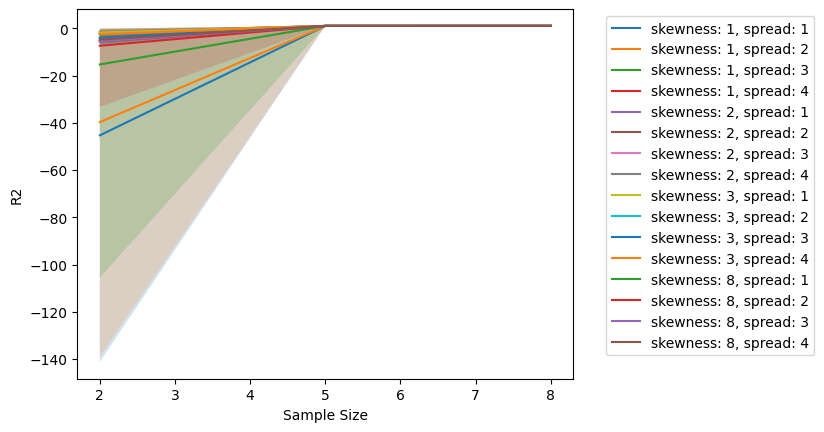

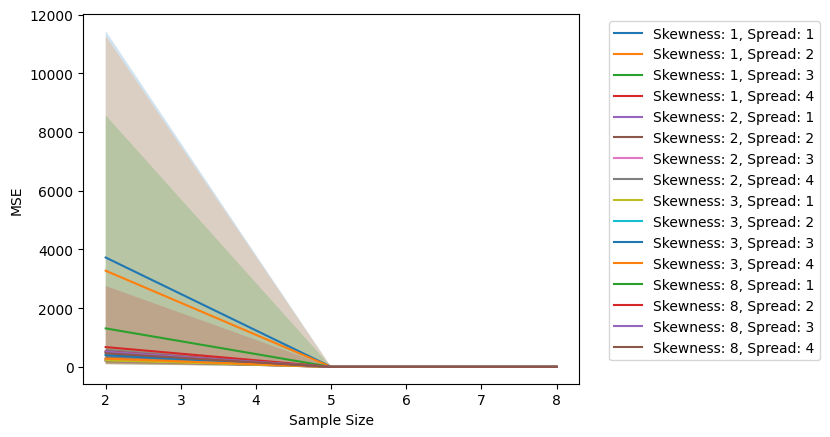

In [22]:
# Plot the results
plt.figure()
for k in results_df["skewness"].unique():
    for theta in results_df["spread"].unique():
        results_df_subset = results_df[(results_df['skewness'] == k) & (results_df['spread'] == theta)]
        plt.plot(results_df_subset['sample_size'], results_df_subset['Mean R2'], label=f"skewness: {k}, spread: {theta}")
        plt.fill_between(results_df_subset['sample_size'], results_df_subset['CI R2'].apply(lambda x: x[0]), results_df_subset['CI R2'].apply(lambda x: x[1]), alpha=0.2)
plt.xlabel("Sample Size")
plt.ylabel("R2")
# plt.xlim(2, 10)
# plt.ylim(-1, 1)
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.show()

plt.figure()
for k in results_df["skewness"].unique():
    for theta in results_df["spread"].unique():
        results_df_subset = results_df[(results_df['skewness'] == k) & (results_df['spread'] == theta)]
        plt.plot(results_df_subset['sample_size'], results_df_subset['Mean MSE'], label=f"Skewness: {k}, Spread: {theta}")
        plt.fill_between(results_df_subset['sample_size'], results_df_subset['CI MSE'].apply(lambda x: x[0]), results_df_subset['CI MSE'].apply(lambda x: x[1]), alpha=0.2)
plt.xlabel("Sample Size")
plt.ylabel("MSE")
# plt.xlim(2, 10)
# plt.ylim(-1, 1)
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.show()


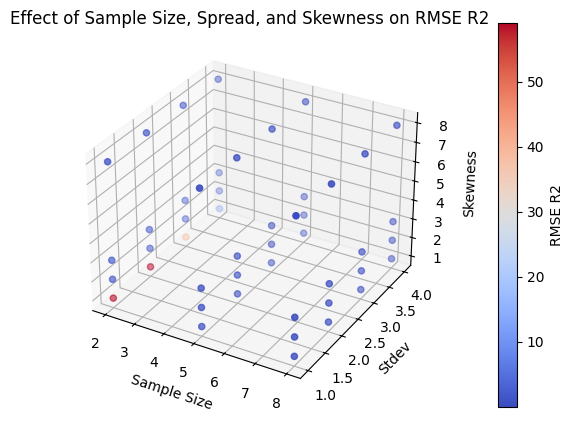

In [23]:
# Visualize results
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
sc = ax.scatter3D(results_df['sample_size'], results_df['spread'], results_df['skewness'], c=results_df['RMSE R2'], cmap='coolwarm')

ax.set_xlabel('Sample Size')
ax.set_ylabel('Stdev')
ax.set_zlabel('Skewness')
ax.set_title('Effect of Sample Size, Spread, and Skewness on RMSE R2')

# Create a new axes for the colorbar
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # adjust the [left, bottom, width, height] as needed
fig.colorbar(sc, cax=cax, label='RMSE R2')

plt.show()

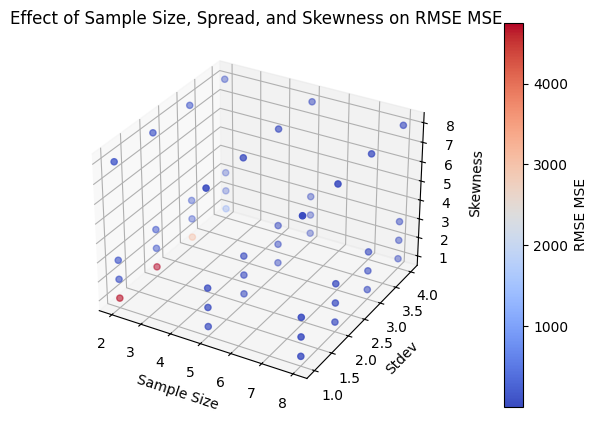

In [24]:
# Visualize results
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
sc = ax.scatter3D(results_df['sample_size'], results_df['spread'], results_df['skewness'], c=results_df['RMSE MSE'], cmap='coolwarm')

ax.set_xlabel('Sample Size')
ax.set_ylabel('Stdev')
ax.set_zlabel('Skewness')
ax.set_title('Effect of Sample Size, Spread, and Skewness on RMSE MSE')

# Create a new axes for the colorbar
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # adjust the [left, bottom, width, height] as needed
fig.colorbar(sc, cax=cax, label='RMSE MSE')

plt.show()

Here we see that the n_bins (sample size) is most important. For low amount of n_bins, the stdev and skewness affects it. But as soon as the n_bins hit 3/4 bins, the stdev and skewness doesn't matter (change parameters).

Another thing that needs to be checked is the amount of stdev per bin for which there is enough R2. Here, noise is added to the sample data points and we keep track how well the mean and stdev is performing by iterating over multiple times. (Could be CI as well)

In [25]:
results_bin_df.head()
print(results_bin_df['sample_size'].unique())
print(results_bin_df['skewness'].unique())
print(results_bin_df['spread'].unique())

[2 5 8]
[1 2 3 8]
[1 2 3 4]


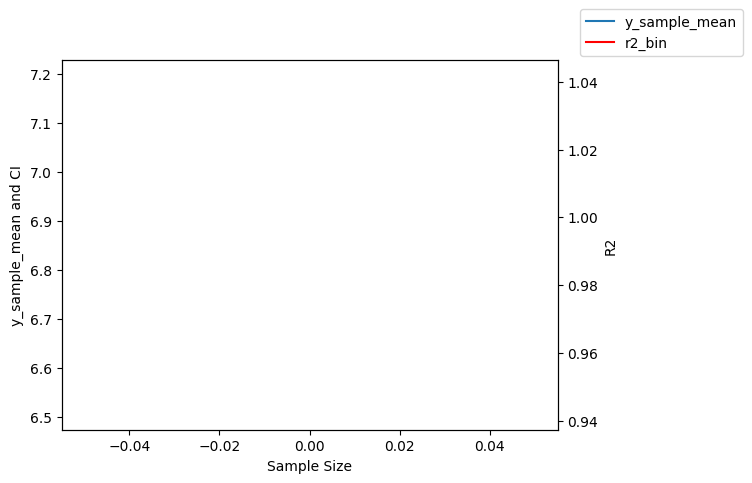

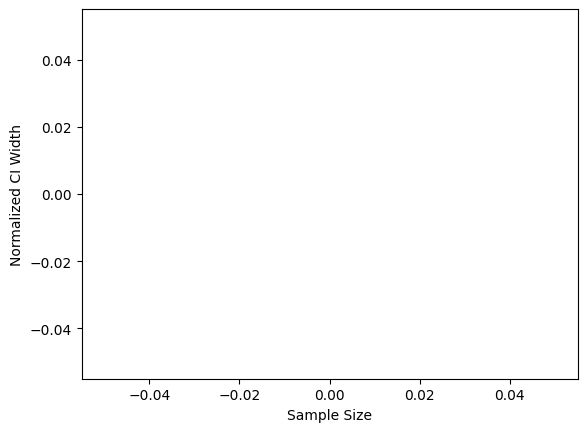

In [26]:
# Plot the bin results, compare how for 2 bins the mean, CI and R2 and RMSE change
n_sample = 5
k = 2
theta = 1

# Subset the data
results_bin_df_subset = results_bin_df[(results_bin_df['sample_size'] == n_sample) & (results_bin_df['skewness'] == k) & (results_bin_df['spread'] == theta)]

# Get groups 
true_indices = results_bin_df_subset[results_bin_df_subset['r2_satisfactory'] == True].index
data = results_bin_df_subset.loc[true_indices[1]+1:true_indices[2]]
# print(data)

fig, ax1 = plt.subplots()
ax1.plot(np.arange(len(data)), data['y_sample_mean'], label='y_sample_mean')
ax1.fill_between(np.arange(len(data)), data['y_sample_ci'].apply(lambda x: x[0]), data['y_sample_ci'].apply(lambda x: x[1]), alpha=0.2)

ax2 = ax1.twinx()
ax2.plot(np.arange(len(data)), data['r2_bin'], label='r2_bin', color='r')

ax1.set_xlabel("Sample Size")
ax1.set_ylabel("y_sample_mean and CI")
ax2.set_ylabel("R2")

fig.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()

# Plot normalised CI width
fig, ax = plt.subplots()
ax.plot(np.arange(len(data)), data['ci_width'], label='ci_width')
ax.set_xlabel("Sample Size")
ax.set_ylabel("Normalized CI Width")
plt.show()



Now you see that the amount of bins filled should be at least 3, where the k and theta don't matter anymore. The main thing is that there should be enough data
in each bin so that a sufficient R2 is reached. But how long does this take?

In the previous dataset the bins where on the x-axis (ABP bins), in the time dataset, the ABP bins are on the y-axis. Now we can just use the Gamma-distribution over the y-axis, where we draw in time datapoints and get an average ABP, which counts for that bin. The average ABP is taken over delta_time = 100

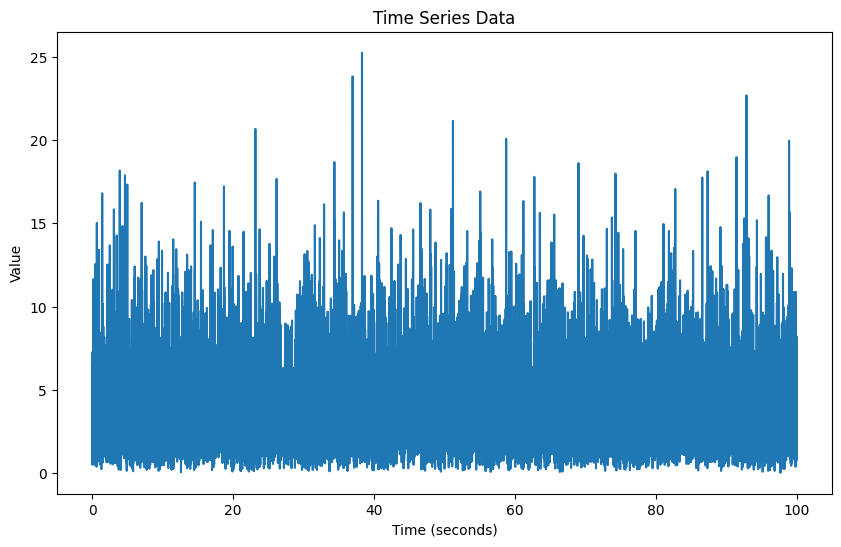

In [27]:
# Generate time series data where the y-values are a stochastic process following a gamma distribution with a certain skewness and spread.

# Define the parameters
shape = 2  # skewness
scale = 2  # spread
size = 100  # number of data points
fs = 100  # sampling frequency

# Generate the time series data
time_values = np.arange(0, size, 1/fs)  # time values in seconds with increased sampling rate
y_values = np.random.gamma(shape, scale, len(time_values))  # adjust the size to match time_values

# Create a DataFrame
df = pd.DataFrame({'Time': time_values, 'Value': y_values})

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Value'])
plt.title('Time Series Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Value')
plt.show()

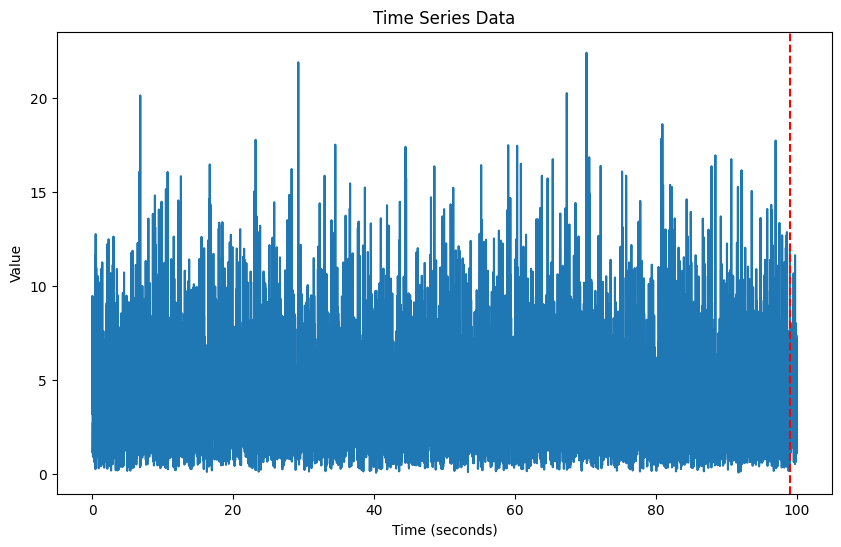

In [28]:
# Now for each n_datapoints = 100, get the mean value and CI normalised width for each bin size. The bins are x = np.linspace(0, 10, 10).
# Calculate how long it takes to fill n_bins = 3 and each bin has a normalised CI width of 0.1.

# 1. Generate n_datapoints = 100 data points following a gamma distribution.
# 2. Create bins using x = np.linspace(0, 10, 10).
# 3. For each bin:
#    1. Calculate the mean value of the data points in the bin.
#    2. Calculate the CI width of the data points in the bin.
#    3. Normalize the CI width by dividing it by the mean.
# 4. Initialize a counter to 0.
# 5. Repeat steps 3-4 until the normalized CI width for a bin is less than or equal to 0.1.
#    1. If it is, increment the counter.
# 6. The time it takes to fill n_bins = 3 is the number of iterations it takes for the counter to reach 3.

shape = 2  # skewness
scale = 2  # spread
n_datapoints = 100  # number of data points
fs = 100  # sampling frequency
bins = np.linspace(0, 10, 10)

# Generate the time series data
time_values = np.arange(0, n_datapoints, 1/fs)  # time values in seconds with increased sampling rate
y_values = np.random.gamma(shape, scale, len(time_values))  # adjust the size to match time_values

# Create a DataFrame
df = pd.DataFrame({'Time': time_values, 'Value': y_values})

# Initialize the bin_means list
bin_means = [[] for _ in range(len(bins)-1)]

# For each n_datapoints
for i in range(0, len(y_values), n_datapoints):
    # Calculate the mean of the n_datapoints
    mean = np.mean(y_values[i:i+n_datapoints])
    
    # Determine which bin the mean belongs to
    bin_index = np.digitize(mean, bins) - 1
    
    # Add the mean to the corresponding bin
    bin_means[bin_index].append(mean)
    
    # If there are at least 2 means in the bin, calculate the CI width
    if len(bin_means[bin_index]) >= 2:
        ci_width = stats.norm.interval(0.95, loc=np.mean(bin_means[bin_index]), scale=np.std(bin_means[bin_index]))
        
        # Normalize the CI width
        normalized_ci_width = (ci_width[1] - ci_width[0]) / (2 * np.mean(bin_means[bin_index]))
        
        # If the normalized CI width is less than or equal to 0.1, add the bin to the filled bins
        if normalized_ci_width <= 0.1:
            bin_means[bin_index].append(normalized_ci_width)
    
    # If at least 3 bins have a normalized CI width less than or equal to 0.1, break the loop
    if len([bin for bin in bin_means if len(bin) >= 3]) >= 3:
        break

# The time it takes to fill 3 bins is the number of iterations it took for the counter to reach 3
time_to_fill_3_bins = (i + 1)

# Get the corresponding time from the DataFrame
time_to_fill_3_bins = df["Time"].iloc[time_to_fill_3_bins]

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Value'])
plt.axvline(x=time_to_fill_3_bins, color='r', linestyle='--')  # add a vertical line at the time_to_fill_3_bins
plt.title('Time Series Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Value')
plt.show()

In [29]:
time_to_fill_3_bins
i+ 1

9901

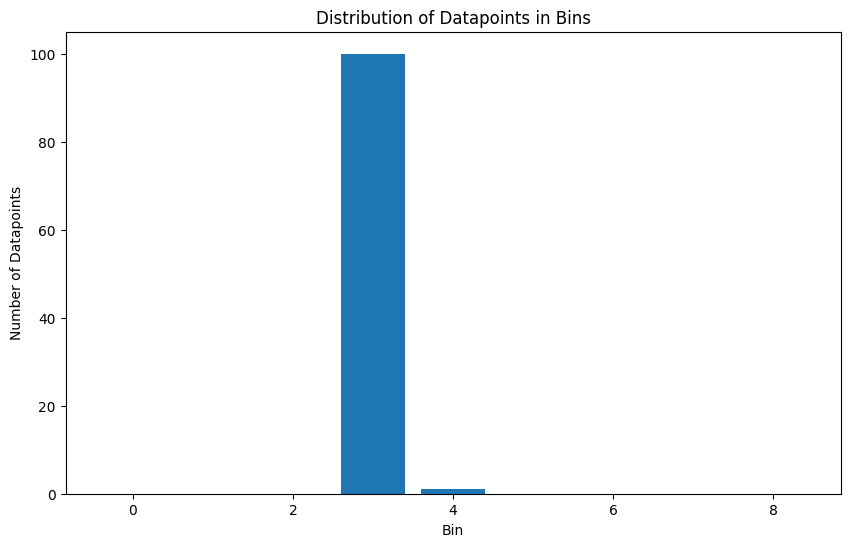

In [30]:
# Calculate the number of datapoints in each bin
datapoints_per_bin = [len(bin) for bin in bin_means]

# Create a DataFrame
df_bins = pd.DataFrame({'Bin': range(len(bins)-1), 'Datapoints': datapoints_per_bin})

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(df_bins['Bin'], df_bins['Datapoints'])
plt.title('Distribution of Datapoints in Bins')
plt.xlabel('Bin')
plt.ylabel('Number of Datapoints')
plt.show()

R2: 0.9764567983510799


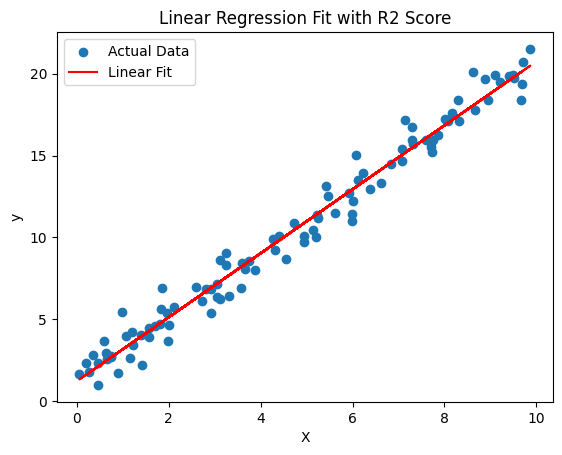

In [31]:
# Generate random data
np.random.seed(42)
X = np.random.rand(100, 1) * 10
y_true = 2 * X.squeeze() + 1 + np.random.randn(100)  # Linear relationship with noise

# Fit a linear model
model = LinearRegression()
model.fit(X, y_true)
y_pred = model.predict(X)

# Calculate R-squared value
r_squared = r2_score(y_true, y_pred)
print("R2:", r_squared)

# Plot the data and the linear fit
plt.scatter(X, y_true, label='Actual Data')
plt.plot(X, y_pred, color='red', label='Linear Fit')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Linear Regression Fit with R2 Score')
plt.show()

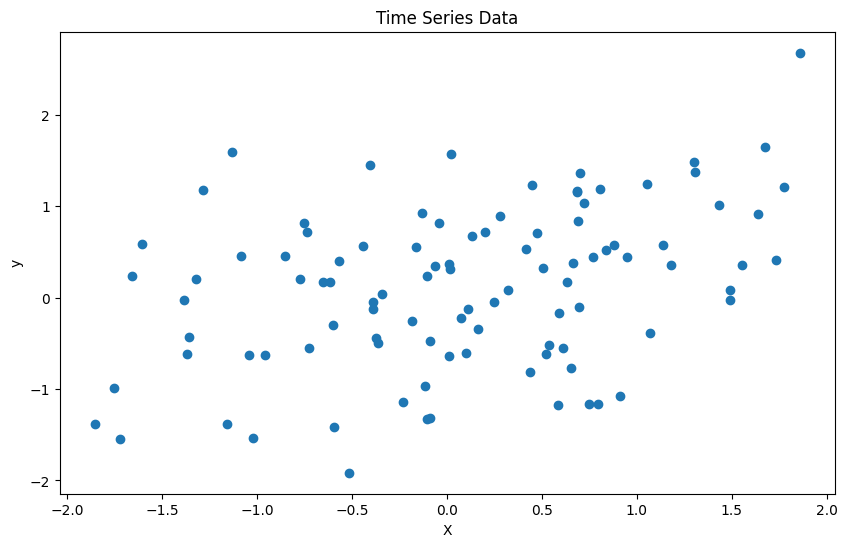

In [32]:
# Simulate time series data with a multivariate normal distribution, as this inidicates a correlation pattern between the datasets

# set a random seed for reproducibility
np.random.seed(42)

# number of datapoints
num_points = 100

# mean and covariance matrix
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]]

# generate the data
data = np.random.multivariate_normal(mean=mean, cov=cov, size=num_points).T

# plot the data
plt.figure(figsize=(10, 6))
plt.scatter(data[0], data[1])
plt.title('Time Series Data')
plt.xlabel('X')
plt.ylabel('y')
plt.show()



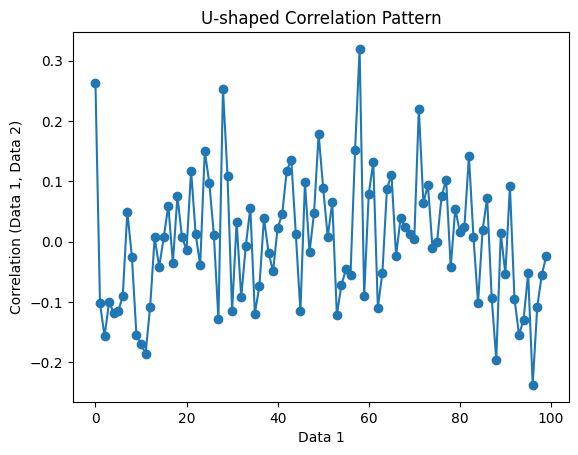

In [33]:
# Set a random seed for reproducibility
np.random.seed(42)

# Number of data points
num_points = 100

# Mean and covariance matrix for the bivariate normal distribution
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]]  # Modify the covariance matrix for the desired correlation structure

# Generate samples from the bivariate normal distribution
data = np.random.multivariate_normal(mean=mean, cov=cov, size=num_points)

# Extract individual time series data
data1 = data[:, 0]
data2 = data[:, 1]

# Create a U-shaped correlation pattern
coefficients = np.linspace(-1, 1, num_points)
data2 = data2 + coefficients

# Normalize the data to have zero mean and unit variance
data1 = (data1 - np.mean(data1)) / np.std(data1)
data2 = (data2 - np.mean(data2)) / np.std(data2)

# Shift the elements of data2 by each possible number of positions
data2_shifts = [np.roll(data2, -i) for i in range(num_points)]

# Calculate the correlation coefficient between data1 and each shifted version of data2
corr_values = [np.corrcoef(data1, data2_shift)[0, 1] for data2_shift in data2_shifts]

# Plot the U-shaped correlation pattern
plt.plot(range(num_points), corr_values, marker='o')
plt.xlabel('Data 1')
plt.ylabel('Correlation (Data 1, Data 2)')
plt.title('U-shaped Correlation Pattern')
plt.show()



/home/jantine/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/jantine/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/jantine/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


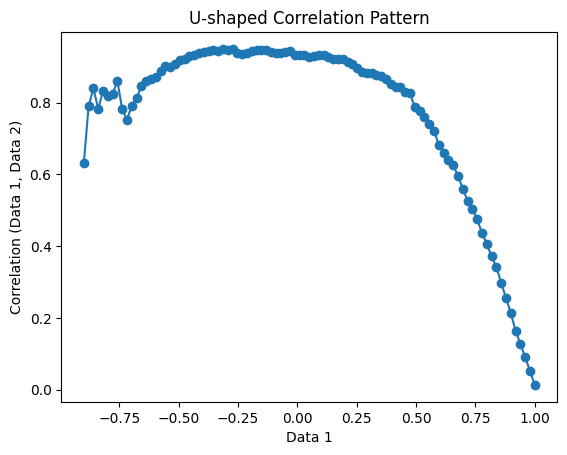

In [34]:
# Set a random seed for reproducibility
np.random.seed(42)

# Number of data points
num_points = 100

# Generate data1 from a uniform distribution
data1 = np.linspace(-1, 1, num_points)

# Generate data2 as a function of data1 with added noise
data2 = -data1**2 + np.random.normal(0, 0.1, num_points)

# Calculate the correlation coefficient between data1 and data2 for each point
corr_values = [np.corrcoef(data1[:i], data2[:i])[0, 1] for i in range(1, num_points+1)]

# Plot the U-shaped correlation pattern
plt.plot(data1[5:], corr_values[5:], marker='o')
plt.xlabel('Data 1')
plt.ylabel('Correlation (Data 1, Data 2)')
plt.title('U-shaped Correlation Pattern')
plt.show()

/tmp/ipykernel_233417/738823923.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby('bins')['corr_values'].agg(['mean', 'std'])


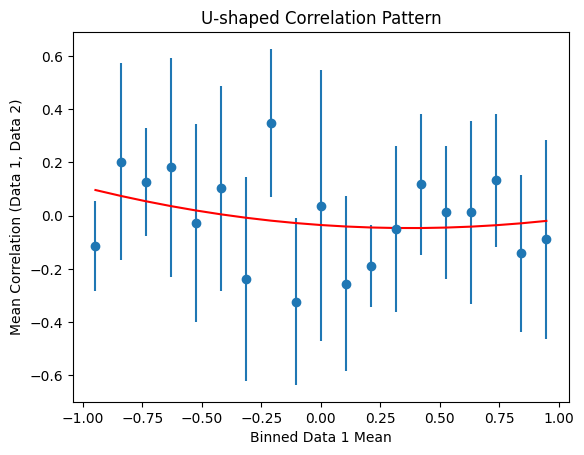

In [35]:
# Set a random seed for reproducibility
np.random.seed(42)

# Number of data points
num_points = 1000

# Generate data1 from a uniform distribution
data1 = np.linspace(-1, 1, num_points)

# Generate data2 as a function of data1 with added noise
data2 = -data1**2 + np.random.normal(0, 0.1, num_points)  # Increase the magnitude of the quadratic term

# Calculate the correlation coefficient between data1 and data2 for each n=10
n = 10
corr_values = [np.corrcoef(data1[i:i+n], data2[i:i+n])[0, 1] for i in range(0, num_points, n)]
data1_mean = [np.mean(data1[i:i+n]) for i in range(0, num_points, n)]

# Create a DataFrame
df = pd.DataFrame({'data1_mean': data1_mean, 'corr_values': corr_values})

# Define bins
bins = np.linspace(-1, 1, 20)

# Group by bins
df['bins'] = pd.cut(df['data1_mean'], bins)

# Calculate mean and std of corr_values in each bin
df_grouped = df.groupby('bins')['corr_values'].agg(['mean', 'std'])

# Fit a second-degree polynomial to the data
coefficients = np.polyfit(df_grouped.index.categories.mid, df_grouped['mean'], 2)
poly = np.poly1d(coefficients)

# Plot the U-shaped correlation pattern
plt.errorbar(x=df_grouped.index.categories.mid, y=df_grouped['mean'], yerr=df_grouped['std'], fmt='o')
plt.plot(df_grouped.index.categories.mid, poly(df_grouped.index.categories.mid), 'r-')
plt.xlabel('Binned Data 1 Mean')
plt.ylabel('Mean Correlation (Data 1, Data 2)')
plt.title('U-shaped Correlation Pattern')
plt.show()

/tmp/ipykernel_233417/1148403743.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby('bins')['corr_values'].agg(['mean', 'std'])


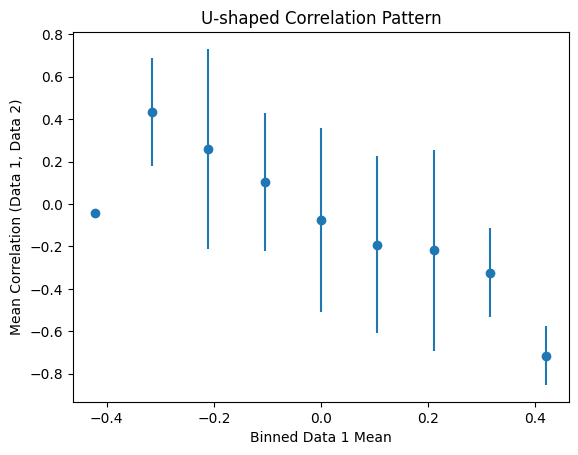

In [36]:
# Set a random seed for reproducibility
np.random.seed(42)

# Number of data points
num_points = 1000

# Generate data1 from a uniform distribution
data1 = np.random.uniform(-1, 1, num_points)

# Generate data2 as a quadratic function of data1 with added noise
# The noise is normally distributed and its standard deviation is proportional to the absolute value of data1
data2 = -data1**2 + np.random.normal(0, np.abs(data1), num_points)

# Calculate the correlation coefficient between data1 and data2 for each n=10
n = 10
corr_values = [np.corrcoef(data1[i:i+n], data2[i:i+n])[0, 1] for i in range(0, num_points, n)]
data1_mean = [np.mean(data1[i:i+n]) for i in range(0, num_points, n)]

# Create a DataFrame
df = pd.DataFrame({'data1_mean': data1_mean, 'corr_values': corr_values})

# Define bins
bins = np.linspace(-1, 1, 20)

# Group by bins
df['bins'] = pd.cut(df['data1_mean'], bins)

# Calculate mean and std of corr_values in each bin
df_grouped = df.groupby('bins')['corr_values'].agg(['mean', 'std'])

# Fit a second-degree polynomial to the data
coefficients = np.polyfit(df_grouped.index.categories.mid, df_grouped['mean'], 2)
poly = np.poly1d(coefficients)

# Plot the U-shaped correlation pattern
plt.errorbar(x=df_grouped.index.categories.mid, y=df_grouped['mean'], yerr=df_grouped['std'], fmt='o')
plt.plot(df_grouped.index.categories.mid, poly(df_grouped.index.categories.mid), 'r-')
plt.xlabel('Binned Data 1 Mean')
plt.ylabel('Mean Correlation (Data 1, Data 2)')
plt.title('U-shaped Correlation Pattern')
plt.show()

In the following example:

- ABP data is generated randomly using a normal distribution.
- The autoregulation response is computed as a simple difference between the current ABP and the ABP delayed by a specified time (autoregulation_delay).
- The blood flow is updated based on the autoregulation response, creating a dynamic relationship between ABP and blood flow.

You can adjust the parameters (autoregulation_strength, autoregulation_delay, etc.) based on the specific characteristics you want to simulate for autoregulation. Keep in mind that this is a simplistic model, and real autoregulation mechanisms can be more complex. More sophisticated models may involve differential equations or other physiological considerations.

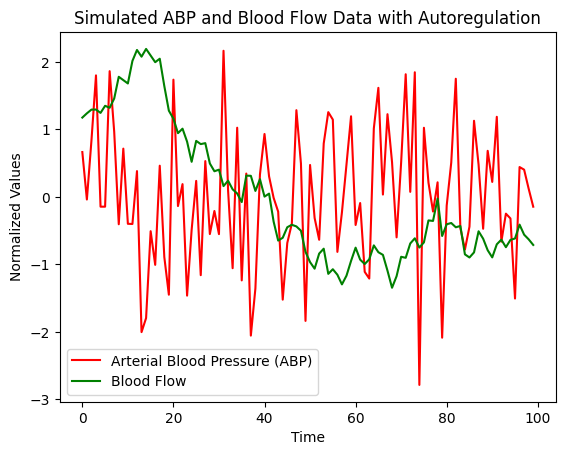

In [37]:

# Set a random seed for reproducibility
np.random.seed(42)

# Number of data points
num_points = 100

# Autoregulation parameters
autoregulation_strength = 0.5
autoregulation_delay = 5  # Number of time steps for the response to take effect

# Simulate ABP data
mean_abp = 80
std_abp = 10
abp = np.random.normal(loc=mean_abp, scale=std_abp, size=num_points)

# Initialize blood flow data
blood_flow = np.zeros(num_points)

# Simulate autoregulation
for t in range(1, num_points):
    # Autoregulation response
    autoregulation_response = autoregulation_strength * (abp[t - autoregulation_delay] - mean_abp)
    
    # Update blood flow based on autoregulation
    blood_flow[t] = blood_flow[t - 1] + autoregulation_response

# Normalize the data to have zero mean and unit variance
abp = (abp - np.mean(abp)) / np.std(abp)
blood_flow = (blood_flow - np.mean(blood_flow)) / np.std(blood_flow)

# Plot the simulated data
plt.plot(abp, label='Arterial Blood Pressure (ABP)', color='red')
plt.plot(blood_flow, label='Blood Flow', color='green')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.title('Simulated ABP and Blood Flow Data with Autoregulation')
plt.legend()
plt.show()


I apologize for the confusion. The U-shape correlation between PRx and MAP is a complex physiological phenomenon that might not be easily simulated with a simple model. The model we have here is quite simplistic and might not be able to capture the U-shape correlation accurately.

However, we can try to modify the `simulate_autoregulation` function to simulate a U-shaped PRx vs MAP relationship. We can do this by making the autoregulation response a function of the absolute difference between the current ABP and a certain optimal ABP value. When the current ABP is close to the optimal ABP, the autoregulation response (and thus the PRx value) will be low. When the current ABP is far from the optimal ABP, the autoregulation response will be high.

Here's how you can modify the `simulate_autoregulation` function:



/home/jantine/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jantine/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jantine/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jantine/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/jantine/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


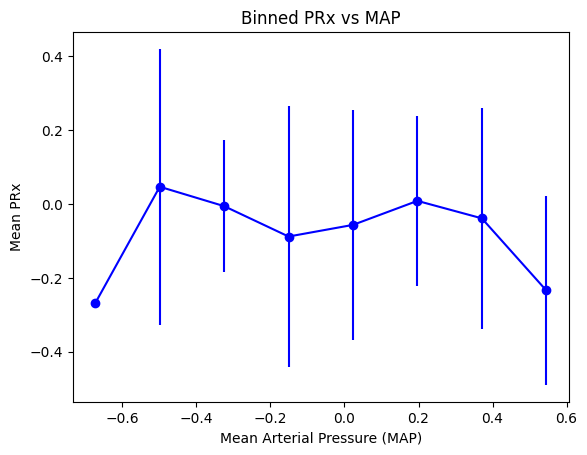

In [38]:
# Function to simulate autoregulation
def simulate_autoregulation(num_points, autoregulation_strength, autoregulation_delay, mean_abp=80, std_abp=10, optimal_abp=80):
    np.random.seed(42)
    abp = np.random.normal(loc=mean_abp, scale=std_abp, size=num_points)
    blood_flow = np.zeros(num_points)

    for t in range(autoregulation_delay, num_points):
        autoregulation_response = autoregulation_strength * abs(abp[t - autoregulation_delay] - optimal_abp)
        blood_flow[t] = blood_flow[t - 1] + autoregulation_response

    abp = (abp - np.mean(abp)) / np.std(abp)
    blood_flow = (blood_flow - np.mean(blood_flow)) / np.std(blood_flow)

    return abp, blood_flow

# Function to calculate PRx (correlation between ABP and blood flow) and MAP values
def calculate_prx_and_map(abp, blood_flow, window_size=10):
    prx_values = np.zeros(len(abp) - window_size + 1)
    map_values = np.zeros(len(abp) - window_size + 1)

    for i in range(len(abp) - window_size + 1):
        prx_values[i] = np.corrcoef(abp[i:i + window_size], blood_flow[i:i + window_size])[0, 1]
        map_values[i] = np.mean(abp[i:i + window_size])

    return prx_values, map_values

# Simulation parameters
num_points = 100
autoregulation_strength = 0.5
autoregulation_delay = 5

# Simulate autoregulation
abp, blood_flow = simulate_autoregulation(num_points, autoregulation_strength, autoregulation_delay)

# Calculate PRx and MAP values
prx_values, map_values = calculate_prx_and_map(abp, blood_flow)

# Bin MAP values and calculate mean and stdev of PRx within each bin
map_bins = np.linspace(min(map_values), max(map_values), 10)
mean_prx_values = []
stdev_prx_values = []

for i in range(len(map_bins) - 1):
    mask = np.logical_and(map_values >= map_bins[i], map_values < map_bins[i + 1])
    mean_prx_values.append(np.mean(prx_values[mask]))
    stdev_prx_values.append(np.std(prx_values[mask]))

# Plot the binned PRx values against MAP
plt.errorbar((map_bins[:-1] + map_bins[1:]) / 2, mean_prx_values, yerr=stdev_prx_values, fmt='o-', color='blue')
plt.xlabel('Mean Arterial Pressure (MAP)')
plt.ylabel('Mean PRx')
plt.title('Binned PRx vs MAP')
plt.show()
